# How food shapes the World - Ada project

With 7.7 billion people around the world in 2019, food demand outbreak has raised serious concerns regarding productive agricultural land availability. As for now cultivable surface expansion has been the only real solution, this project aims at providing insights on how this problematic is currently shaping the world’s surface as we know it. Investigation will first focus on the kind of environment that are being impinged on. Moving on to the “destructive” impact of certain foodstuffs and diet trends, correlating with international trade flows. This study relies on FAOSTAT data set from the United Nation, helping us in the process.
We endeavor at providing an exhaustive visualization of the world under growing food reshaping pressure. Key features will be surface evolution across time and space, selected crops impact as well as involved parties and areas. Tackling all of the above with both social awareness and self consciousness concerns.

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
from bs4 import BeautifulSoup

## Opening the dataset

First of all, we need to open the dataset on which we are working. That is, loading it and displaying as much of it as possible to get a better view from it.

In [146]:
datapath = "Data/global-food-agriculture-statistics/"
current_fao = "current_FAO/raw_files/"

savanna = pd.read_csv(datapath + current_fao + "Emissions_Agriculture_Burning_Savanna_E_All_data_(Norm).csv", sep=",", encoding="ANSI")  # Less savanna
crops = pd.read_csv(datapath + "fao_data_crops_data.csv", sep=",", encoding="UTF-8")                                                     # Where every products are planted
forests = pd.read_csv(datapath + current_fao + "Emissions_Land_Use_Forest_Land_E_All_Data_(Norm).csv", sep=",", encoding="ANSI")         # Less forests
livestock = pd.read_csv(datapath + current_fao + "Trade_Crops_Livestock_E_All_Data_(Normalized).csv", sep=",", encoding="ANSI")          # Imports and exports 
item_codes=pd.read_csv(datapath + current_fao +"export_items_1574515779.csv",sep=";", encoding="latin_1")#FAO commodities item codes 

We will now scrap a another dataset, investigate each dataset and start to correlate them depending on the questions we want to answer for Milestone 3. 

### Table of contents

1. [Countries areas](#areas)
2. [Savanna](#savanna) 
3. [Forests](#forests)
4. [Biomes](#merge)
5. [Crops](#crops)
6. [Livestock](#livestock)
7. [Data to answer the questions](#questions)

<a id="areas"></a>
### Countries areas

Since we will need it later, we start by webscraping the areas of all coutries from wikipedia website. We store clean the dataset and store it in a dataframe :

In [3]:
URL = "https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_area" # wikipedia URL to get the information

r = requests.get(URL)

soup = BeautifulSoup(r.text, 'html.parser')

In [4]:
byCountries = soup.find_all('tr') # each rows for each country is between 'tr' tags
byCountries = byCountries[2:-7]   # remove rows containing no usefull information
byCountries[0]

<tr>
<td><span data-sort-value="5000000000000000000♠" style="display:none"></span> –</td>
<td style="text-align:left;"><span class="flagicon" style="padding-left:25px;"> </span><a href="/wiki/World" title="World">World</a></td>
<td><span data-sort-value="7014510072000000000♠"></span>510,072,000<br/>(196,940,000)</td>
<td><span data-sort-value="7014148940000000000♠"></span>148,940,000<br/>(57,510,000)</td>
<td><span data-sort-value="7014361132000000000♠"></span>361,132,000<br/>(139,434,000)</td>
<td>70.8</td>
<td style="text-align:left;">
</td></tr>

In [5]:
country_areas = []
for r in byCountries:
    tds = r.find_all('td')  
    country = r.find('a').get('title') # Get the name of the country
    values = []
    for p in tds[2:5]: # The values of interest are stored in the second to fourth td tags
        if(len(p.contents) > 0):
            if isinstance(p.contents[1], str): # consider the column if it is a string (and not a tag or something else)
                values += [p.contents[1]]
            else:
                values += "Not determined"
        else:
            values += ["-"]
    country_areas.append({"Country" : country, "Total(km2)" : values[0], "Land(km2)" : values[1], "Water(km2)" : values[2]})

In [6]:
country_areas = pd.DataFrame.from_dict(country_areas)
country_areas

,Country,Total(km2),Land(km2),Water(km2)
0,World,"510,072,000","148,940,000","361,132,000"
1,Russia,"17,098,246","16,377,742","720,500"
2,Antarctica,"14,000,000","14,000,000",0
3,Canada,"9,984,670","9,093,507","891,163"
4,China,"9,596,961","9,326,410","270,550"
...,...,...,...,...
257,Clipperton Island,6,2,4
258,Ashmore and Cartier Islands,5,5,0
259,Spratly Islands,< 5,< 5,0
260,Coral Sea Islands,< 3,< 3,0


In [7]:
# Clean the dataframe (cast numbers from string to float, remove symbols like " ' " or "<" and rename non existent data)
country_areas["Total(km2)"] = country_areas["Total(km2)"].apply(lambda x: re.sub(r"[^0-9.]", "", x))
country_areas["Land(km2)"] = country_areas["Land(km2)"].apply(lambda x: re.sub(r"[^0-9.]", "", x))
country_areas["Water(km2)"] = country_areas["Water(km2)"].apply(lambda x: re.sub(r"[^0-9.]", "", x))

country_areas["Total(km2)"] = country_areas["Total(km2)"].apply(lambda x: "Not determined" if x == '' else float(x))
country_areas["Land(km2)"] = country_areas["Land(km2)"].apply(lambda x: "Not determined" if x == '' else float(x))
country_areas["Water(km2)"] = country_areas["Water(km2)"].apply(lambda x: "Notdetermined" if x == '' else float(x))

country_areas = country_areas.drop_duplicates(subset="Country", keep="first").sort_values(by="Total(km2)", ascending=False)

In [8]:
# Convert km2 in Ha and rename (we don't need the unit anymore, as we know that we use Ha for all datasets)
country_areas['Total(km2)'] = country_areas['Total(km2)']*100
country_areas['Land(km2)'] = country_areas['Land(km2)']*100
country_areas['Water(km2)'] = country_areas['Water(km2)']*100
#as everything is in ha  we just remove the units from the titles:
country_areas = country_areas.rename(columns={"Total(km2)":"Total", "Land(km2)":"Land", "Water(km2)":"Water"})

In [9]:
country_areas

,Country,Total,Land,Water
0,World,5.100720e+10,1.4894e+10,3.61132e+10
1,Russia,1.709825e+09,1.63777e+09,7.205e+07
2,Antarctica,1.400000e+09,1.4e+09,0
3,Canada,9.984670e+08,9.09351e+08,8.91163e+07
4,China,9.596961e+08,9.32641e+08,2.7055e+07
...,...,...,...,...
257,Clipperton Island,6.000000e+02,200,400
258,Ashmore and Cartier Islands,5.000000e+02,500,0
259,Spratly Islands,5.000000e+02,500,0
260,Coral Sea Islands,3.000000e+02,300,0


In [10]:
export_path = r'Data\country_areas.csv'
export_csv = country_areas.to_csv(export_path, index = None, header=True)

<a id="savanna"></a>
### Savanna

In [11]:
savanna.dtypes

Country Code      int64
Country          object
Item Code         int64
Item             object
Element Code      int64
Element          object
Year Code         int64
Year              int64
Unit             object
Value           float64
Flag             object
dtype: object

In [12]:
savanna.head(1)

,Country Code,Country,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,6760,Savanna,7246,Burned Area,1990,1990,Ha,0.9251,Fc


#### Description:
In this dataframe we have the following columns:
- Country Code: One specific number per country
- Country: list of country
- Item Code: One specific number per Item
- Item: A list of different ecosystems
- Element Code: One specific munber per element
- Element: What was actually calculated, measured or estimated
- Year Code: One specific number per year (same as the year)
- Year: The actual year
- Unit: What is the unit of the value of "Value"
- Value: The value found for the element
- Flag: Info on where the data comes from (Fc, A, NaN, F)

There is a total of 50'000 rows.

All the years are registred since 1990 until 2014. There is then prediction for year 2030 and 2050.

There is a total of 275 country like entries

#### Selection of useful data
As we are only interested in the area lost to burnings. We can do a first selection:

In [13]:
savannaSurface = savanna[savanna['Element'].str.match('Burned Area')]
savannaSurface.head()

,Country Code,Country,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,6760,Savanna,7246,Burned Area,1990,1990,Ha,0.9251,Fc
1,2,Afghanistan,6760,Savanna,7246,Burned Area,1991,1991,Ha,0.9251,Fc
2,2,Afghanistan,6760,Savanna,7246,Burned Area,1992,1992,Ha,0.9251,Fc
3,2,Afghanistan,6760,Savanna,7246,Burned Area,1993,1993,Ha,0.9251,Fc
4,2,Afghanistan,6760,Savanna,7246,Burned Area,1994,1994,Ha,0.9251,Fc


In [14]:
savanna.Item.drop_duplicates()

0                         Savanna
207                 Woody savanna
444              Closed shrubland
685                Open shrubland
928                     Grassland
1169     Burning - all categories
1358    Savanna and woody savanna
1547    Closed and open shrubland
Name: Item, dtype: object

Here is a list of all the different type of ecosystem on which we have data. It seems to contain 2 types of savana, two type of shrubland and grassland. In addition, the tree last categories are aparently agglomeration of the other items.
Lets verify that:
- The Savanna and woody savanna contains the values under the item Savanna and woody savanna.
- Closed and open shrubland contains the values under the item closed shrubland and open shrubland.
- Burning - all categories is a sum of all the types of ecosystem.

To do that:

In [15]:
world_90 = savannaSurface.Value[(savannaSurface['Year']==1990)  & (savannaSurface['Country']=='World')].tolist()
print('Total Savana : ', world_90[0] + world_90[1],' is equal to ', world_90[6])
print('Total shrubland : ', world_90[2] + world_90[3],' is equal to ', world_90[7])
print('Total Surfaces : ', sum(world_90[:5]), ' is equal to ', world_90[5])

Total Savana :  245098958.1444  is equal to  245098958.1444
Total shrubland :  26547260.456800003  is equal to  26547260.4567
Total Surfaces :  311619836.7884  is equal to  311619836.7883


Our hypothesis were indeed correct. There are three main categories: Savana, Shrubland and grassland with subcategories. We also have the total surfaces burned in "Burning - all categories".

We only keep the main Categories: Savana, Shrubland and grassland:

In [16]:
savannaSurface = savannaSurface[(savannaSurface['Item']=='Savanna and woody savanna') | (savannaSurface['Item']=='Closed and open shrubland') | (savannaSurface['Item']=='Grassland')]
savannaSurface = savannaSurface.replace('Savanna and woody savanna','Savanna')
savannaSurface = savannaSurface.replace('Closed and open shrubland','Shrubland')

Now, to have a better synergy between all the datasets we are using in this project. We need to keep only the years that are available in all the dataset. For this matter, we chose to study from 1995 to 2007. 

In [17]:
savannaSurface = savannaSurface[(savannaSurface['Year']>1994) & (savannaSurface['Year']<2008)]
savannaSurface.head(2)

,Country Code,Country,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
933,2,Afghanistan,6794,Grassland,7246,Burned Area,1995,1995,Ha,2323.1605,Fc
934,2,Afghanistan,6794,Grassland,7246,Burned Area,1996,1996,Ha,5349.2426,NaN


Let's examinate the countries:
The last 37 Countries of the column country do not contain countries, but the entire world and other group of countries.

In [18]:
savannaSurface.Country.drop_duplicates()
print(savannaSurface.Country.drop_duplicates())
print(savannaSurface.Country.drop_duplicates().head(-36))

933                                   Afghanistan
2657                                      Albania
4425                                      Algeria
5991                               American Samoa
7503                                      Andorra
                           ...                   
426067          Low Income Food Deficit Countries
427579    Net Food Importing Developing Countries
429091                          Annex I countries
430603                      Non-Annex I countries
432115                                       OECD
Name: Country, Length: 268, dtype: object
933          Afghanistan
2657             Albania
4425             Algeria
5991      American Samoa
7503             Andorra
               ...      
371075    Western Sahara
372587             Yemen
374447            Zambia
376229          Zimbabwe
377795             World
Name: Country, Length: 232, dtype: object


In this project we want to find the burned areas by countries. Two other dataframes are also organized to have the burned area for specific regions like continants and for specific alliances or groups of countries, for exemple the OCDE.

In [19]:
savannaCountry = savannaSurface.truncate(after=377033)
savannaCountry.head(2)

,Country Code,Country,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
933,2,Afghanistan,6794,Grassland,7246,Burned Area,1995,1995,Ha,2323.1605,Fc
934,2,Afghanistan,6794,Grassland,7246,Burned Area,1996,1996,Ha,5349.2426,NaN


In [20]:
savannaRegion = savannaSurface.truncate(before=377033, after=420013)
savannaRegion.head(2)

,Country Code,Country,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
377795,5000,World,6794,Grassland,7246,Burned Area,1995,1995,Ha,3.997362e+07,A
377796,5000,World,6794,Grassland,7246,Burned Area,1996,1996,Ha,3.501767e+07,A


In [21]:
savannaEconomical_segment = savannaSurface.truncate(before=420014)
savannaEconomical_segment.head(2)

,Country Code,Country,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
420019,5706,European Union,6794,Grassland,7246,Burned Area,1995,1995,Ha,15107.9292,A
420020,5706,European Union,6794,Grassland,7246,Burned Area,1996,1996,Ha,17201.5004,A


Now we want to get rid of all the useless column:
- Flag: It won't directly interest us. Just good to keep in mind that not all our data was collected in the same way
- Unit: We are only dealing with [ha] now
- Element: We only consider Burned Area, so no need to keep it in the dataframe
- [...] Code: Do not really contain information

In [22]:
savannaCountry = savannaCountry.drop(['Flag', 'Unit','Year Code', 'Element', 'Element Code','Country Code', 'Item Code'], axis=1)\
                             .rename(columns={"Value": "Area_loss","Item": "Ecosystem"})
savannaRegion = savannaRegion.drop(['Flag', 'Unit','Year Code', 'Element', 'Element Code','Country Code', 'Item Code'], axis=1)\
                             .rename(columns={"Value": "Area_loss","Item": "Ecosystem"})
savannaEconomical_segment = savannaEconomical_segment.drop(['Flag', 'Unit','Year Code', 'Element', 'Element Code','Country Code', 'Item Code'], axis=1)\
                             .rename(columns={"Value": "Area_loss","Item": "Ecosystem"})

Here is a summary of our three dataframes:

In [23]:
savannaCountry.head()

,Country,Ecosystem,Year,Area_loss
933,Afghanistan,Grassland,1995,2323.1605
934,Afghanistan,Grassland,1996,5349.2426
935,Afghanistan,Grassland,1997,1191.8687
936,Afghanistan,Grassland,1998,19674.0298
937,Afghanistan,Grassland,1999,6007.4143


In [24]:
savannaEconomical_segment.head()

,Country,Ecosystem,Year,Area_loss
420019,European Union,Grassland,1995,15107.9292
420020,European Union,Grassland,1996,17201.5004
420021,European Union,Grassland,1997,12652.5053
420022,European Union,Grassland,1998,26379.4422
420023,European Union,Grassland,1999,17202.5408


In [25]:
savannaRegion.head()

,Country,Ecosystem,Year,Area_loss
377795,World,Grassland,1995,3.997362e+07
377796,World,Grassland,1996,3.501767e+07
377797,World,Grassland,1997,3.447965e+07
377798,World,Grassland,1998,4.058443e+07
377799,World,Grassland,1999,3.825170e+07


#### Analysis of the desired value:
In this dataset, only the total burned area interests us. Here is the description of the values:

In [26]:
savannaCountry['Area_loss'].describe()

count    8.883000e+03
mean     4.689319e+05
std      2.622205e+06
min      0.000000e+00
25%      0.000000e+00
50%      9.508650e+01
75%      1.058393e+04
max      3.932319e+07
Name: Area_loss, dtype: float64

Let's plot the data to see how it looks like: 
- The plot is done for the 8 more conserned countries
- The plot is done for savanna, another ecosystem will change the top 8 countries and obviously the area lost

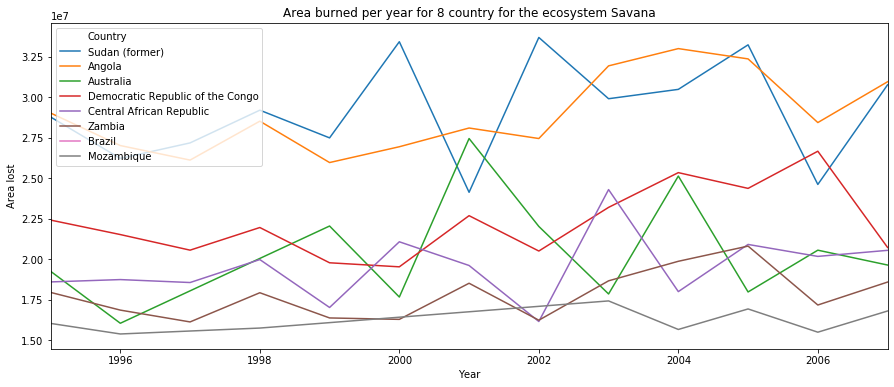

In [27]:
z= savannaCountry[savannaCountry['Ecosystem'] == 'Savanna']\
                        .groupby(['Year','Country'])['Area_loss']\
                        .sum()\
                        .sort_values(ascending = False)\
                        .to_frame()[:85]\
                        .reset_index()
plt.figure(figsize=(15,6))


ax = sns.lineplot(x="Year", y="Area_loss", hue="Country", data=z)

ax.set_title('Area burned per year for 8 country for the ecosystem Savana')
ax.set_xlim([1995,2007]);
plt.xlabel('Year');
plt.ylabel('Area lost');

We see on the plot that our values are widely distributed. Indeed here we plot the countries with the biggest loses but a lot of other countries have 0 loses or near 0 values. If needed, a log scale can be used to see them clearly.

#### Use of Savanna

The final dataframe: "savannaFinal" will be joined to the forest one to answer to the following question:
- What is the global evolution of the cultivated surface on a world scale from 1995 to 2007?
- What is the area lost of savanna, shrubland, grassland and forest per country per year?
- Do we see a correlation between the area lost by ecosystems and the area gain by agriculture?
- If there is a correlation between an increase in area cultivated and area lost from all the ecosystems, what would be approximatively the area lost because of the selected crops in particular?

<a id="forests"></a>
### Forests

In [28]:
forests = pd.read_csv(datapath + current_fao + "Emissions_Land_Use_Forest_Land_E_All_Data_(Norm).csv", sep=",", encoding="ANSI")         # Less forests
forests.dtypes

Country Code      int64
Country          object
Item Code         int64
Item             object
Element Code      int64
Element          object
Year Code         int64
Year              int64
Unit             object
Value           float64
Flag             object
dtype: object

In [29]:
forests

,Country Code,Country,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,6661,Forest,5110,Area,1990,1990,1000 Ha,1350.0000,F
1,2,Afghanistan,6661,Forest,5110,Area,1991,1991,1000 Ha,1350.0000,F
2,2,Afghanistan,6661,Forest,5110,Area,1992,1992,1000 Ha,1350.0000,F
3,2,Afghanistan,6661,Forest,5110,Area,1993,1993,1000 Ha,1350.0000,F
4,2,Afghanistan,6661,Forest,5110,Area,1994,1994,1000 Ha,1350.0000,F
...,...,...,...,...,...,...,...,...,...,...,...
73062,5873,OECD,6749,Forest land,72172,Net emissions/removal (CO2eq) (Forest land),2011,2011,Gigagrams,-818448.2103,A
73063,5873,OECD,6749,Forest land,72172,Net emissions/removal (CO2eq) (Forest land),2012,2012,Gigagrams,-818448.2103,A
73064,5873,OECD,6749,Forest land,72172,Net emissions/removal (CO2eq) (Forest land),2013,2013,Gigagrams,-818448.2103,A
73065,5873,OECD,6749,Forest land,72172,Net emissions/removal (CO2eq) (Forest land),2014,2014,Gigagrams,-818448.2103,A


#### Description :

As you can see above, this dataset contains the same columns as savanna.

It contains 73067 rows and it is registered by year for each Country, item and element from 1990 to 2015. 

In [30]:
forests.shape

(73067, 11)

#### Selection of useful data : 

In [31]:
print(pd.Series.unique(forests.Item))
print(pd.Series.unique(forests.Element))

['Forest' 'Net Forest conversion' 'Forest land']
['Area' 'Implied emission factor for CO2'
 'Net emissions/removals (CO2) (Forest land)'
 'Net emissions/removal (CO2eq) (Forest land)']


We see that we have three different possible items. For this project, we only care about the biomes that are destructed, therefore we only keep the item "Net Forest Conversion" which represent the area of deforestation (for agriculture, mines, urbanisation, ...). We also see that we have multiple possible elements. The area is the one of interest for us. 

In [32]:
forests = forests.query("Item == 'Net Forest conversion'")
forests = forests.query("Element == 'Area'")
forests.shape

(6817, 11)

As we can see, we only have 6817 rows left already. What about the Flag column now ?

In [33]:
print(pd.Series.unique(forests.Flag))

['Fc' 'A']


We have two kind of flags : 
- "Fc" which tells that the data is only calculated
- "A" which tells that the data is aggregated and may include official, semi-official estimated or calculated data

We don't really care how the data was collected. Therefore, we will remove this column. 

In [34]:
forests = forests.drop(columns="Flag")

Looking at the unit of the areas, we see that it is in 1000 Ha. To be consistent with the Savanna dataset, we need to convert the area into a unit of 1 Ha (and then remove the unit colum alltogether):

In [35]:
forests.Value = forests.Value*1000
forests = forests.drop(columns="Unit")

Then, we will also remove the column Element, since we our dataframe only contains area now. We will also remove code columns and do some renaming to be consistent with Savanna. Finally a rename "Net Forest Conversion" into "Forest" since it is clear from our project that we only consider lost areas:

In [36]:
forests = forests.drop(columns=["Item Code", "Element Code", "Year Code", "Element"])
forests = forests.rename(columns={"Item":"Ecosystem", "Value":"Area_loss"})
forests.Ecosystem = "Forest" 
# Based on results from other datasets, we only keep data between 1995 and 2007 :
forests = forests[forests.Year >= 1995]
forests = forests[forests.Year <= 2007]
forests

,Country Code,Country,Ecosystem,Year,Area_loss
109,2,Afghanistan,Forest,1995,0.0
110,2,Afghanistan,Forest,1996,0.0
111,2,Afghanistan,Forest,1997,0.0
112,2,Afghanistan,Forest,1998,0.0
113,2,Afghanistan,Forest,1999,0.0
...,...,...,...,...,...
72924,5873,OECD,Forest,2003,1725477.4
72925,5873,OECD,Forest,2004,1725477.4
72926,5873,OECD,Forest,2005,1725477.4
72927,5873,OECD,Forest,2006,2187015.0


In [37]:
forests.isna().drop_duplicates()

,Country Code,Country,Ecosystem,Year,Area_loss
109,False,False,False,False,False


As we can see above, there are no na/Nan values inside this dataframe.

Now about the countries. Looking at the country code, it seems like there are 5873 different countries ? What about the actual countries : 

In [38]:
pd.Series.nunique(forests.Country)

267

There are only 272 country like elements, which makes more sense. let see the country code:

In [39]:
pd.Series.unique(forests["Country Code"])

array([   2,    3,    4,    5,    6,    7,  258,    8,    9,    1,   22,
         10,   11,   52,   12,   13,   16,   14,   57,  255,   15,   23,
         53,   17,   18,   19,   80,   20,   21,  239,   26,   27,  233,
         29,   35,  115,   32,   33,   36,   37,   39,  259,   40,  351,
         41,   44,   45,   46,   47,   48,  107,   98,   49,   50,  167,
        116,  250,   54,   72,   55,   56,   58,   59,   60,   61,  178,
         63,  238,   65,   64,   66,   67,   68,   69,   70,   74,   75,
         73,   79,   81,   82,   84,   85,   86,   87,   88,   89,   90,
        175,   91,   93,   95,   97,   99,  100,  101,  102,  103,  104,
        264,  105,  106,  109,  110,  112,  108,  114,   83,  118,  113,
        120,  119,  121,  122,  123,  124,  125,  126,  256,  129,  130,
        131,  132,  133,  134,  127,  135,  136,  137,  270,  138,  145,
        141,  273,  142,  143,  144,   28,  147,  148,  149,  150,  151,
        153,  156,  157,  158,  159,  160,  161,  1

We see that there is something special with the numbering of the country : Some numbers are not there (232 for example), but more importantly, the numbers jump to around 5'000. What data is contained whith these 5'000+ country codes? 

Apprently, these "countries" are in fact geographical and economical regions/continent. We will store them in different dataframes, as in Savanna, for later use : 

In [40]:
forestsCountry = forests[forests["Country Code"] < 5000].drop(columns="Country Code")
forestsRegion_eco = forests[forests["Country Code"] >= 5000]
forestsRegion = forestsRegion_eco[forestsRegion_eco["Country Code"] < 5700].drop(columns="Country Code")
forestsEconomical_segment = forestsRegion_eco[forestsRegion_eco["Country Code"] >= 5700].drop(columns="Country Code")
forests = forests.drop(columns="Country Code")

In [41]:
forestsCountry.head(5)

,Country,Ecosystem,Year,Area_loss
109,Afghanistan,Forest,1995,0.0
110,Afghanistan,Forest,1996,0.0
111,Afghanistan,Forest,1997,0.0
112,Afghanistan,Forest,1998,0.0
113,Afghanistan,Forest,1999,0.0


In [42]:
forestsRegion.head(5)

,Country,Ecosystem,Year,Area_loss
64510,World,Forest,1995,13029740.8
64511,World,Forest,1996,13029740.8
64512,World,Forest,1997,13029740.8
64513,World,Forest,1998,13029740.8
64514,World,Forest,1999,13029740.8


In [43]:
forestsEconomical_segment.head(5)

,Country,Ecosystem,Year,Area_loss
71044,European Union,Forest,1995,266140.1
71045,European Union,Forest,1996,266140.1
71046,European Union,Forest,1997,266140.1
71047,European Union,Forest,1998,266140.1
71048,European Union,Forest,1999,266140.1


#### Analysis of the desired value

In [44]:
forestsCountry["Area_loss"].describe()

count    2.948000e+03
mean     5.562358e+04
std      2.156696e+05
min      0.000000e+00
25%      0.000000e+00
50%      2.000000e+01
75%      1.700000e+04
max      2.996800e+06
Name: Area_loss, dtype: float64

Nothing much is to be said on this datasets, as it is very similar to Savanna, only with different actual values. We will analyze more of it later when we work on the merged data and do the true work for milestone 3.

<a id="merge"></a>
# Biomes

#### Merge of all the Biomes Data Set

In this section we will merge all the final dataframe from Savanna, Forests and from the datascraping. From this we will get three dataframes, one for the seperation by countries, one for the region and one for the economic segments. These dataset will be refered to as `Biomes` in the section 7: "Data to answer the questions".

In [377]:
# First we add the forest ecosystem to the ones from savanna for the Country datasets
lossesCountry = forestsCountry.append(savannaCountry)

# We add to this  the data from the scraping to get the total land area of each country
land_areas = country_areas[["Country", "Land"]]
biomesCountry = land_areas.merge(lossesCountry, on='Country')
# Compute the percentage:
biomesCountry['Area_loss_percentage'] = biomesCountry['Area_loss']/biomesCountry['Land'].astype('int')*100
#'Area_loss_number' is a column that will just help to plot the data on a logscale:
biomesCountry['Area_loss_number'] = (biomesCountry['Area_loss_percentage']*1e8).astype('float')
#biomesCountry['Area_loss_number'] = (biomesCountry['Area_loss_percentage']*1e8).astype('int')
biomesCountry.head()
#biomesCountry['Area_loss_percentage'].describe()

,Country,Land,Ecosystem,Year,Area_loss,Area_loss_percentage,Area_loss_number
0,Canada,9.09351e+08,Forest,1995,523800.0,0.057602,5.760154e+06
1,Canada,9.09351e+08,Forest,1996,523800.0,0.057602,5.760154e+06
2,Canada,9.09351e+08,Forest,1997,523800.0,0.057602,5.760154e+06
3,Canada,9.09351e+08,Forest,1998,523800.0,0.057602,5.760154e+06
4,Canada,9.09351e+08,Forest,1999,523800.0,0.057602,5.760154e+06


In [46]:
# The same is done for the region but without the total area
biomesRegion = forestsRegion.append(savannaRegion)
biomesRegion.head()

,Country,Ecosystem,Year,Area_loss
64510,World,Forest,1995,13029740.8
64511,World,Forest,1996,13029740.8
64512,World,Forest,1997,13029740.8
64513,World,Forest,1998,13029740.8
64514,World,Forest,1999,13029740.8


In [47]:
#The same is done for the economic segment:
biomesEconomical_segment = forestsEconomical_segment.append(savannaEconomical_segment)
biomesEconomical_segment.head()

,Country,Ecosystem,Year,Area_loss
71044,European Union,Forest,1995,266140.1
71045,European Union,Forest,1996,266140.1
71046,European Union,Forest,1997,266140.1
71047,European Union,Forest,1998,266140.1
71048,European Union,Forest,1999,266140.1


<a id="crops"></a>
# Crops

The dataset `Crops` give us informations about distribution of crops in different areas over the years. We investigate this data set more in details in the file `Crops.ipynb` and will only present here the conclusive data sets and analysis. 

In [147]:
crops.dtypes

country_or_area     object
element_code        object
element             object
year               float64
unit                object
value              float64
value_footnotes     object
category            object
dtype: object

In [148]:
crops.shape

(2255349, 8)

In [151]:
crops.head()

,country_or_area,element_code,element,year,unit,value,value_footnotes,category
0,Americas +,31,Area Harvested,2007.0,Ha,49404.0,A,agave_fibres_nes
1,Americas +,31,Area Harvested,2006.0,Ha,49404.0,A,agave_fibres_nes
2,Americas +,31,Area Harvested,2005.0,Ha,49404.0,A,agave_fibres_nes
3,Americas +,31,Area Harvested,2004.0,Ha,49113.0,A,agave_fibres_nes
4,Americas +,31,Area Harvested,2003.0,Ha,48559.0,A,agave_fibres_nes


## Discussion on the Investigation

From investigation following, we describe each features of the dataFrame: \
   * `country_or_area`: area where the product is cultivated. From the investigation, we observe different regroupments for those areas. They can correspond to countries, regions such as continents or even the world or economical regroupments such as `Low Income Food Deficit Countries`. 
   * `element`: gives us a number of different informations about the adding of the crops. We have lot of information on PIN, which is a production index qualifying the land needed per unit of crop production in 1961.We also have informations on  Seeds and Yields. IN order to answer our specific question, we will only keep `Area Harvested` and `ProductionQuantity`, respectively in Hectars and Tonnes as it can be seen in the feature `unit`. From now on, the data frames will be generated for both elements. 
   * `year`: the years are from 1961 to 2007. As the datasets `Savanna` and `Forests` are restricted to 1990, we choose to start at 1990 too in order to be able to conduct correlations. From the investigation, we can see that th enumber of data is uneven through time with a lot less data in the older years. 
   * `value`: feature of biggest interest as it will give us the corresponding value. Units are given in the `unit` feature and correspond to the information said in `element`.
   * `category`: the sort of product that is concerned by the informations. From the investigation, we see that there are also regroupments. Hence, we can find products by themselves such as `Bananas` or groups of products such as `cereals_total`. 
   
We decided to present the results for the products in two parts. First, we will observe the phenomena globally, by countries and using all the products all together. in the second part, we will work on only 5 specific food products in order to have a specific idea of the phenomena. We chose `Bananas`, `palm_oil`, `sojabean`, `banana`, `wheat`, `rice` because we though that they are a good compromise between the top ranked products for productiona and area harvested and top ranked products for inport and export. We want to be able to see interesting and different results, that is why if we realize that products in the list present similar results, we let us the possibility to take another one. 
    
Let's start the investigation. We will now investigate each features in order to have an idea of what kind of information we have.

## Investigation of Crops
### Element Code 
Let's start the investigation by understanding what categories of inforamtions we have.  


In [152]:
crops.groupby('element_code').count()

,country_or_area,element,year,unit,value,value_footnotes,category
element_code,,,,,,,
111,204568,204568,204568,204568,204568,188064,204568
152,9399,9399,9399,9399,9399,9399,9399
154,9399,9399,9399,9399,9399,9399,9399
31,671153,671153,671153,671153,671153,473111,671153
41,631078,631078,631078,631078,631078,615683,631078
432,9145,9145,9145,9145,9145,9145,9145
434,9145,9145,9145,9145,9145,9145,9145
436,9145,9145,9145,9145,9145,9145,9145
438,9145,9145,9145,9145,9145,9145,9145


We can see that for elements that are not numbers, the data seem to be missing.

In [153]:
crops.loc[crops.element_code == 'FAO Estimate']

,country_or_area,element_code,element,year,unit,value,value_footnotes,category
2401,F,FAO Estimate,NaN,NaN,NaN,NaN,NaN,agave_fibres_nes
11396,F,FAO Estimate,NaN,NaN,NaN,NaN,NaN,almonds_with_shell
20081,F,FAO Estimate,NaN,NaN,NaN,NaN,NaN,anise_badian_fennel_corian
34985,F,FAO Estimate,NaN,NaN,NaN,NaN,NaN,apples
46753,F,FAO Estimate,NaN,NaN,NaN,NaN,NaN,apricots
...,...,...,...,...,...,...,...,...
2194131,F,FAO Estimate,NaN,NaN,NaN,NaN,NaN,walnuts_with_shell
2213221,F,FAO Estimate,NaN,NaN,NaN,NaN,NaN,watermelons
2239308,F,FAO Estimate,NaN,NaN,NaN,NaN,NaN,wheat
2252286,F,FAO Estimate,NaN,NaN,NaN,NaN,NaN,yams


It seems to be because for those categories of elements, the values are NaN. We won't be able to fill them so we remove them. 

### Value Footnotes
From the `FAO website`, we see that it corresponds to how the data were collected. The information won't help us for our questions so we remove the feature.

In [154]:
crops.groupby('value_footnotes').count()

,country_or_area,element_code,element,year,unit,value,category
value_footnotes,,,,,,,
A,974473,974473,974473,974473,974473,974473,974473
F,264501,264501,264501,264501,264501,264501,264501
Fc,386744,386744,386744,386744,386744,386744,386744
NR,150249,150249,150249,150249,150249,150249,150249


In [155]:
#remove value_footnotes and element_code
crops = crops.drop(columns=['value_footnotes', 'element_code'])

In [156]:
# remove missing values
crops = crops.dropna()
crops.shape

(2254385, 6)

In [157]:
crops.sort_values('value', ascending=False)

,country_or_area,element,year,unit,value,category
455824,World +,Production Quantity,2007.0,tonnes,2.351396e+09,cereals_total
455827,World +,Production Quantity,2004.0,tonnes,2.280834e+09,cereals_total
455826,World +,Production Quantity,2005.0,tonnes,2.267177e+09,cereals_total
455825,World +,Production Quantity,2006.0,tonnes,2.239236e+09,cereals_total
363756,World +,Production Quantity,2007.0,tonnes,2.131753e+09,cereals_rice_milled_eqv
...,...,...,...,...,...,...
1329116,Belize,Yield,1984.0,Hg/Ha,0.000000e+00,onions_inc_shallots_green
1329115,Belize,Yield,1985.0,Hg/Ha,0.000000e+00,onions_inc_shallots_green
1329114,Belize,Yield,1986.0,Hg/Ha,0.000000e+00,onions_inc_shallots_green
1329113,Belize,Yield,1987.0,Hg/Ha,0.000000e+00,onions_inc_shallots_green


We can still see a lot of 0 values. We will keep them for now.\
### Element

Now let's observe a little bit more what kind of data are given. 

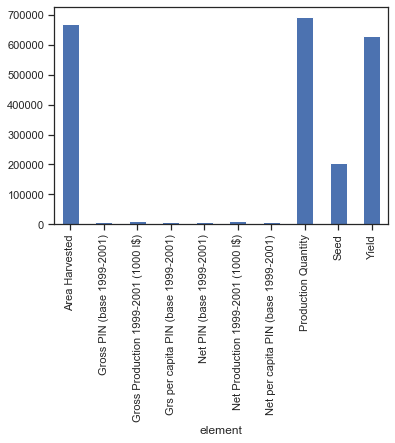

In [158]:
elements = crops.copy()
elements = elements.groupby('element').count()
elements['value'].plot(kind='bar')

In [159]:
#look at the order of values for the different elements 
#here look at 'Gross PIN (base 1999-2001)''
crops.loc[crops.element == 'Gross PIN (base 1999-2001)'].head()

,country_or_area,element,year,unit,value,category
364728,Afghanistan,Gross PIN (base 1999-2001),2007.0,Int. $,235.0,cereals_total
364729,Afghanistan,Gross PIN (base 1999-2001),2006.0,Int. $,188.0,cereals_total
364730,Afghanistan,Gross PIN (base 1999-2001),2005.0,Int. $,221.0,cereals_total
364731,Afghanistan,Gross PIN (base 1999-2001),2004.0,Int. $,144.0,cereals_total
364732,Afghanistan,Gross PIN (base 1999-2001),2003.0,Int. $,180.0,cereals_total


In [160]:
crops.loc[crops.element == 'Net Production 1999-2001 (1000 I$)'].head()

,country_or_area,element,year,unit,value,category
364587,Afghanistan,Net Production 1999-2001 (1000 I$),2007.0,1000 Int. $,861765.0,cereals_total
364588,Afghanistan,Net Production 1999-2001 (1000 I$),2006.0,1000 Int. $,679843.0,cereals_total
364589,Afghanistan,Net Production 1999-2001 (1000 I$),2005.0,1000 Int. $,803456.0,cereals_total
364590,Afghanistan,Net Production 1999-2001 (1000 I$),2004.0,1000 Int. $,511338.0,cereals_total
364591,Afghanistan,Net Production 1999-2001 (1000 I$),2003.0,1000 Int. $,652969.0,cereals_total


PIN: production index = land needed per unit of crop production in 1961 (in 1961 = 1): it won't interest us because it will be hard to put it in correlation to the other data sets. 

Gross PIN (base 1999-2001): not interessted \
Gross Production 1999-2001 (1000 dollars): not interested in looking at monetary values \
Grs per capita PIN (base 1999-2001): not interested in PIN \
Net PIN (base 1999-2001): not interested in PIN \
Net per capita PIN (base 1999-2001): not interested in PIN \
Net Production 1999-2001 (1000 dollars): not interested in looking at monetary values

We won't be interested by all of that. We can also remove `Seed` and `Yield` \
Hence we only keep `Area Harvested` and `Production Quantity` that we separate in 2 tables.

In [161]:
# create one df for the elements we are not interested, another for the 2 interesting elements
crops_no_interest = crops.loc[~(crops.element=='Area Harvested')\
                                     & ~(crops.element=='Production Quantity')] #every elements except the 2 of interest 
crops_interest = crops.drop(crops_no_interest.index, axis=0)

### Unit 

Now we only have 2 elements. We want to check that they indeed don't have the same units and tha twe need to separate them in 2 different df.

In [162]:
crops_interest[(crops_interest.unit=='Ha') & (crops_interest.element=='Production Quantity')]

,country_or_area,element,year,unit,value,category


As they don't have the same unit, we need to separate them in 2 different tables.\
Now we can look at the other informations. We will continue the analysis by creating both tables every time as we will need both depending on the question. Nevertheless, we will print the df of only the `Area Harvested` informations for more readability. 


In [163]:
crops_area = crops_interest[crops_interest.element=='Area Harvested'] #in Ha : area added 
crops_prod = crops_interest[crops_interest.element=='Production Quantity'] #in tonnes : production

### Year

Last thing to study before looking at the informations about the products by themselves is the repartition of data over the years. 

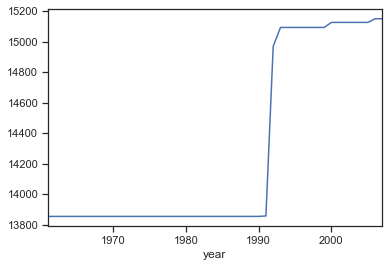

In [164]:
year_area = crops_area.copy()
year_area.groupby('year')['value'].count().plot()

One can see that the number of data over time is very different from 1961 to 2007. An interesting point could be to know if it is due to the development of data collection in the last years or if the difference of entries is really due to the difference of expansion of agriculture. 

### Country or Area 

We need to have both data frame. 

In [165]:
regions_prod = crops_prod.copy()
regions_area = crops_area.copy()

#area harvested for each country/region
regions_area.groupby('country_or_area')["value"].sum().sort_values(ascending=False).to_frame()

,value
country_or_area,
World +,1.599868e+11
Low Income Food Deficit Countries +,7.665792e+10
Asia +,6.836644e+10
Europe +,3.424290e+10
Americas +,3.374058e+10
...,...
US Virgin Islands,1.060000e+04
Faroe Islands,9.732000e+03
Cayman Islands,8.126000e+03


We can see that the areas with the most entries of values consists in regions of the world such as continents or `Low Income Deficit Countries` which corresponds to economical regions, all ending with a `+`. As they regroup a lot of countries, they are not at the same scale as individual countries and we can separate the 3 categories (individual countries vs. areas/regions vs. economical regions).

##### Useful data frames

In [166]:
#specific global areas (regions or economical areas all finish by '+'

#create dataframe for all non-countries areas
crops_regions_area = regions_area[[name.endswith('+') for name in regions_area.country_or_area]]
crops_regions_prod = regions_prod[[name.endswith('+') for name in regions_prod.country_or_area]]

#dataframes for countries
crops_countries_area = regions_area.drop(crops_regions_area.index, axis=0)
crops_countries_prod = regions_prod.drop(crops_regions_prod.index, axis=0)

#list of the economical regions 
economical_segments = ['Least Developed Countries +', 'LandLocked developing countries +',
       'Small Island Developing States +', 'Low Income Food Deficit Countries +', 'Net Food Importing Developing Countries +']

#dataframes for economical areas
crops_eco_area = regions_area.loc[regions_area['country_or_area'].isin(economical_segments)]
crops_eco_prod = regions_prod.loc[regions_prod['country_or_area'].isin(economical_segments)]

#dataframes for regional areas
crops_regions_area = crops_regions_area.loc[~regions_area['country_or_area'].isin(economical_segments)]
crops_regions_prod = crops_regions_prod.loc[~regions_prod['country_or_area'].isin(economical_segments)]

##### Displaying

In [167]:
crops_countries_area

,country_or_area,element,year,unit,value,category
564,Colombia,Area Harvested,2007.0,Ha,17500.0,agave_fibres_nes
565,Colombia,Area Harvested,2006.0,Ha,17500.0,agave_fibres_nes
566,Colombia,Area Harvested,2005.0,Ha,17500.0,agave_fibres_nes
567,Colombia,Area Harvested,2004.0,Ha,17294.0,agave_fibres_nes
568,Colombia,Area Harvested,2003.0,Ha,17094.0,agave_fibres_nes
...,...,...,...,...,...,...
2255056,"Venezuela, Bolivarian Republic of",Area Harvested,1965.0,Ha,11307.0,yautia_cocoyam
2255057,"Venezuela, Bolivarian Republic of",Area Harvested,1964.0,Ha,11318.0,yautia_cocoyam
2255058,"Venezuela, Bolivarian Republic of",Area Harvested,1963.0,Ha,11328.0,yautia_cocoyam
2255059,"Venezuela, Bolivarian Republic of",Area Harvested,1962.0,Ha,11338.0,yautia_cocoyam


In [168]:
#display area harvested by economic areas
crops_eco_area.groupby('country_or_area')["value"].sum().sort_values(ascending=False).to_frame()

,value
country_or_area,
Low Income Food Deficit Countries +,7.665792e+10
Net Food Importing Developing Countries +,2.221224e+10
Least Developed Countries +,1.568426e+10
LandLocked developing countries +,8.058806e+09
Small Island Developing States +,6.466597e+08


In [169]:
#display area harvested by regional areas
crops_regions_area.groupby('country_or_area')["value"].sum().sort_values(ascending=False).to_frame()

,value
country_or_area,
World +,1.599868e+11
Asia +,6.836644e+10
Europe +,3.424290e+10
Americas +,3.374058e+10
Southern Asia +,3.085033e+10
Eastern Europe +,2.396467e+10
Eastern Asia +,2.206147e+10
Africa +,2.097670e+10
Northern America +,1.939848e+10


Even now we can see that some reginal areas are redundant, for example, `Europe` is counted by itself and separated in `Southern Europe`, `Northern Europe`, `Eastern Europe` and `Western Europe`. That explains why the value for `World` is different from the sum of all the rest. \
It is interesting to see that `Low Income Food Deficit Countries` have more areas harvested than the entire `Asia`. We will analyse that further in Milestone 3. 

In [170]:
#display area harvested per countries  
crops_countries_area.groupby('country_or_area')["value"].sum().sort_values(ascending=False).to_frame().head(10)

,value
country_or_area,
India,2.391471e+10
China,2.069723e+10
"China, mainland",2.054710e+10
United States of America,1.569625e+10
USSR,1.495057e+10
Brazil,6.147899e+09
Nigeria,4.088043e+09
Canada,3.702207e+09
Indonesia,3.110258e+09


There are 217 countries listed here. Knowing that there are as of today 195 countries in the world, we will need to consider that over time some countries disappeared, such as `USSR` or that countries are counted twice such as `China` and `China, mainland`.

### Categories of products

Now we are gonna investigate the products by themselves. \
Let's just try to observe results for countries individually as the results would be similar for bigger areas. 

In [171]:
category_area = crops_countries_area.copy()
category_prod = crops_countries_prod.copy()

#area harvested for each products for all countries
category_area.groupby('category')["value"].sum().sort_values(ascending=False).to_frame().head(15)

,value
category,
cereals_total,3.679708e+10
cereals_rice_milled_eqv,3.679708e+10
coarse_grain_total,1.699700e+10
wheat,1.165933e+10
oilcrops_primary,9.207386e+09
oilcakes_equivalent,8.815416e+09
rice_paddy,8.140748e+09
maize,6.927290e+09
pulses_total,3.387550e+09


Here, again, we can see some categorization such as `_total` or `_eqv` that we need to put in another dataframe in order to be able to compare the different products individually on the same scale. 170 different categories of aliments are harvested in total (based on the size of the df). 

##### Useful data frames 

In [221]:
crops_indiv_area = category_area.copy()
crops_indiv_prod = category_prod.copy()

#df with categories of products 
crops_totals_area = crops_indiv_area[[name.endswith('_total') | name.endswith('_eqv') \
                                      | name.endswith('_equivalent') | name.endswith('_primary') \
                                      for name in crops_indiv_area['category']]]
crops_totals_prod = crops_indiv_prod[[name.endswith('_total') | name.endswith('_eqv') \
                                      | name.endswith('_equivalent') | name.endswith('_primary') \
                                      for name in crops_indiv_prod['category']]]

#df with only individual products 
crops_indiv_area = crops_indiv_area.drop(crops_totals_area.index, axis=0)
crops_indiv_prod = crops_indiv_prod.drop(crops_totals_prod.index, axis=0)

##### Displaying 

In [224]:
crops_totals_area.groupby("category")["value"].sum().sort_values(ascending=False).to_frame().head(10)

,value
category,
cereals_total,3.679708e+10
cereals_rice_milled_eqv,3.679708e+10
coarse_grain_total,1.699700e+10
oilcrops_primary,9.207386e+09
oilcakes_equivalent,8.815416e+09
pulses_total,3.387550e+09
roots_and_tubers_total,2.757671e+09
fibre_crops_primary,2.079049e+09
fruit_excl_melons_total,1.973247e+09


(1995, 2007)

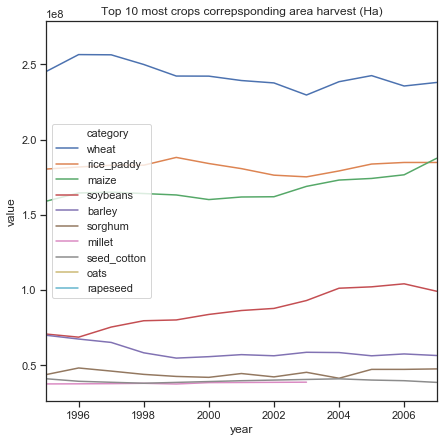

In [178]:
x = crops_indiv_area.groupby(['year','category'])['value']\
                                                    .sum()\
                                                    .sort_values(ascending =False)\
                                                    .to_frame()[:350]\
                                                    .reset_index()
plt.figure(figsize=(7,7))


ax = sns.lineplot(x="year", y="value", hue="category",
                   data=x)

ax.set_title('Top 10 most crops correpsponding area harvest (Ha)')
ax.set_xlim([1995,2007])

In [179]:
crops_indiv_prod.groupby("category")["value"].sum().sort_values(ascending=False).to_frame().head(10)

,value
category,
sugar_cane,4.469464e+10
rice_paddy,2.768484e+10
wheat,2.492530e+10
maize,2.424903e+10
potatoes,1.514378e+10
sugar_beet,1.228800e+10
sweet_potatoes,1.092999e+10
vegetables_fresh_nes,8.518075e+09
barley,6.832736e+09


(1995, 2007)

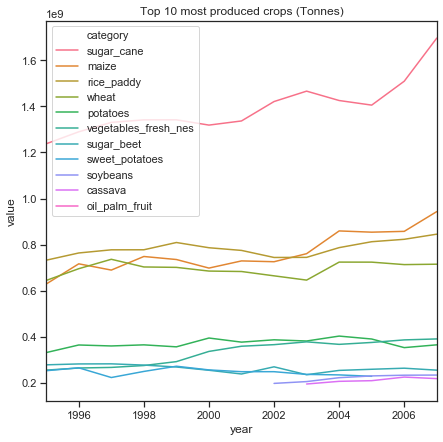

In [180]:
x = crops_indiv_prod.groupby(['year','category'])['value']\
                                                    .sum()\
                                                    .sort_values(ascending =False)\
                                                    .to_frame()[:350]\
                                                    .reset_index()
plt.figure(figsize=(7,7))


ax = sns.lineplot(x="year", y="value", hue="category",
                   data=x)

ax.set_title('Top 10 most produced crops (Tonnes)')
ax.set_xlim([1995,2007])

We see a lot of similarities between top ranked products for `Area Harvested` and `Production Quantities`. We still see some differences that will be interested to study and to put in relationship with the other datasets.

We can also see that some data are missing in certain years for some products.

<a id="livestock"></a>
## Livestock

In [181]:
livestock.dtypes

Area Code         int64
Area             object
Item Code         int64
Item             object
Element Code      int64
Element          object
Year Code         int64
Year              int64
Unit             object
Value           float64
Flag             object
dtype: object

In [182]:
livestock.head(5)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,231,Almonds shelled,5910,Export Quantity,1961,1961,tonnes,0.0,NaN
1,2,Afghanistan,231,Almonds shelled,5910,Export Quantity,1962,1962,tonnes,0.0,NaN
2,2,Afghanistan,231,Almonds shelled,5910,Export Quantity,1963,1963,tonnes,0.0,NaN
3,2,Afghanistan,231,Almonds shelled,5910,Export Quantity,1964,1964,tonnes,0.0,NaN
4,2,Afghanistan,231,Almonds shelled,5910,Export Quantity,1965,1965,tonnes,0.0,NaN


In [79]:
print("total null values: ", livestock.isna().sum().sum())

total null values:  8408201


It seems like a lot of data is missing in Value and Flag sections 
It corresponds to lack of information especially for the value section in which we are the most interested. Lets drop the rows with Value column  missing 



In [80]:
print("old dataframe shape: ",livestock.shape)
clean_live_stocks = livestock.dropna(axis=0, how='any', subset=['Value'])
print( "new dataframe shape: ", clean_live_stocks.shape)


old dataframe shape:  (14566119, 11)
new dataframe shape:  (11748779, 11)


We keep NAN flag for the moment as we don't know how to deal with it \


### Area Investigation

Counting the number of element per features gives additional information compared to unique feature display when it comes to investigation.


In [81]:
intervals = clean_live_stocks.groupby('Area')["Area Code"].count().to_frame().sort_values(by=['Area Code'],ascending=False) 
intervals.head()


,Area Code
Area,
World,95150
Asia,91250
Europe,88384
Net Food Importing Developing Countries,88304
European Union,88189


It seems that not only data contains countries stocks data, but regions, continents and other segments. 

Let us group each area by scale 



In [82]:
regions = ['EU(12)ex.int',
       'EU(15)ex.int', 'EU(25)ex.int', 'EU(27)ex.int',
       'European Union (exc intra-trade)', 'Africa',
       'Eastern Africa', 'Middle Africa', 'Northern Africa',
       'Southern Africa', 'Western Africa', 'Americas',
       'Northern America', 'Central America', 'Caribbean',
       'South America', 'Asia', 'Central Asia', 'Eastern Asia',
       'Southern Asia', 'South-Eastern Asia', 'Western Asia', 'Europe',
       'Eastern Europe', 'Northern Europe', 'Southern Europe',
       'Western Europe', 'Oceania', 'Australia & New Zealand',
       'Melanesia', 'Micronesia', 'Polynesia','World']

economical_segments = ['Least Developed Countries', 'Land Locked Developing Countries',
       'Small Island Developing States',
       'Low Income Food Deficit Countries',
       'Net Food Importing Developing Countries','European Union']

not_countries = regions+economical_segments

countries_live_stock = clean_live_stocks[~clean_live_stocks['Area'].isin(not_countries)].copy()





In [83]:
intervals = countries_live_stock.groupby('Area')["Area Code"].count().to_frame().sort_values(by=['Area Code'],ascending=False) 
intervals.head()

,Area Code
Area,
United Kingdom,82610
Germany,82484
France,81997
Italy,81559
Spain,81264


More developed countries appear more in trade exchanges as other ones less globalized display fewer exchanges. This is consistent with our observations

## Item Investigation

In [84]:
intervals = countries_live_stock.groupby('Item')["Item Code"].count().to_frame().sort_values(by=['Item Code'],ascending=False) 
intervals.head()

,Item Code
Item,
Sugar and Honey,37635
Cereals,37609
Animal Vegetable Oil,37536
Total Meat,37485
Beverages,37471


Lots of items do not correspond to land crops nor food, we should get rid of them and only keep must exchanged landcrops 

FAO crops classifications : 

1 - CEREALS AND CEREAL PRODUCTS\
2 - ROOTS AND TUBERS AND DERIVED PRODUCTS\
3 - SUGAR CROPS AND SWEETENERS AND DERIVED PRODUCTS\
4 - PULSES AND DERIVED PRODUCTS\
5 - NUTS AND DERIVED PRODUCTS\
6 - OIL-BEARING CROPS AND DERIVED PRODUCTS\
7 - VEGETABLES AND DERIVED PRODUCTS\
8 - FRUITS AND DERIVED PRODUCTS\
9 - FIBRES OF VEGETAL AND ANIMAL ORIGIN\
10 - SPICES\
11 - FODDER CROPS AND PRODUCTS\
12 - STIMULANT CROPS AND DERIVED PRODUCTS\
13 - TOBACCO AND RUBBER AND OTHER CROPS\
14 - VEGETABLE AND ANIMAL OILS AND FATS\
15 - BEVERAGES\
16 - LIVESTOCK\
17 - PRODUCTS FROM SLAUGHTERED ANIMALS\
18 - PRODUCTS FROM LIVE ANIMALS\
19 - HIDES AND SKINS\
20 - OTHER LIVESTOCK PRODUCTS\
21 - PESTICIDES\
22 - FERTILIZERS\
23 - MACHINERY




In [85]:
#Processing FAO stat dataset to make it merge compliant with livestock dataset
item_codes=item_codes.drop(columns=['Scientific Name','Common Name','Definition'])
item_codes=item_codes.dropna()
item_codes['FCL Item code']=item_codes['FCL Item code'].apply(lambda x : int(x))
item_codes=item_codes.rename(columns={'FCL Item code':'Item Code','FCL Title':'Item'})




In [86]:
merged_live_crops = pd.merge(clean_live_stocks,item_codes,how='left',on='Item Code')
merged_live_crops=merged_live_crops.drop(columns="Item_y")
merged_live_crops=merged_live_crops.rename(columns={'Item_x':'Item'})
merged_live_crops.head()



,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Group
0,2,Afghanistan,231,Almonds shelled,5910,Export Quantity,1961,1961,tonnes,0.0,NaN,5 - NUTS AND DERIVED PRODUCTS
1,2,Afghanistan,231,Almonds shelled,5910,Export Quantity,1962,1962,tonnes,0.0,NaN,5 - NUTS AND DERIVED PRODUCTS
2,2,Afghanistan,231,Almonds shelled,5910,Export Quantity,1963,1963,tonnes,0.0,NaN,5 - NUTS AND DERIVED PRODUCTS
3,2,Afghanistan,231,Almonds shelled,5910,Export Quantity,1964,1964,tonnes,0.0,NaN,5 - NUTS AND DERIVED PRODUCTS
4,2,Afghanistan,231,Almonds shelled,5910,Export Quantity,1965,1965,tonnes,0.0,NaN,5 - NUTS AND DERIVED PRODUCTS


In [87]:
merged_live_crops.Group.unique()

array(['5 - NUTS AND DERIVED PRODUCTS', '10 - SPICES',
       '8 - FRUITS AND DERIVED PRODUCTS',
       '1 - CEREALS AND CEREAL PRODUCTS', '15 - BEVERAGES',
       '18 - PRODUCTS FROM LIVE ANIMALS',
       '11 - FODDER CROPS AND PRODUCTS',
       '12 - STIMULANT CROPS AND DERIVED PRODUCTS',
       '13 - TOBACCO AND RUBBER AND OTHER CROPS',
       '6 - OIL-BEARING CROPS AND DERIVED PRODUCTS',
       '9 - FIBRES OF VEGETAL AND ANIMAL ORIGIN',
       '14 - VEGETABLE AND ANIMAL OILS AND FATS', '19 - HIDES AND SKINS',
       '3 - SUGAR CROPS AND SWEETENERS AND DERIVED PRODUCTS',
       '17 - PRODUCTS FROM SLAUGHTERED ANIMALS',
       '7 - VEGETABLES AND DERIVED PRODUCTS',
       '2 - ROOTS AND TUBERS AND DERIVED PRODUCTS', nan,
       '4 - PULSES AND DERIVED PRODUCTS', '20 - OTHER LIVESTOCK PRODUCTS'],
      dtype=object)

In [88]:
merged_live_crops.dtypes



Area Code         int64
Area             object
Item Code         int64
Item             object
Element Code      int64
Element          object
Year Code         int64
Year              int64
Unit             object
Value           float64
Flag             object
Group            object
dtype: object

In [89]:
merged_live_crops.Group.unique()

array(['5 - NUTS AND DERIVED PRODUCTS', '10 - SPICES',
       '8 - FRUITS AND DERIVED PRODUCTS',
       '1 - CEREALS AND CEREAL PRODUCTS', '15 - BEVERAGES',
       '18 - PRODUCTS FROM LIVE ANIMALS',
       '11 - FODDER CROPS AND PRODUCTS',
       '12 - STIMULANT CROPS AND DERIVED PRODUCTS',
       '13 - TOBACCO AND RUBBER AND OTHER CROPS',
       '6 - OIL-BEARING CROPS AND DERIVED PRODUCTS',
       '9 - FIBRES OF VEGETAL AND ANIMAL ORIGIN',
       '14 - VEGETABLE AND ANIMAL OILS AND FATS', '19 - HIDES AND SKINS',
       '3 - SUGAR CROPS AND SWEETENERS AND DERIVED PRODUCTS',
       '17 - PRODUCTS FROM SLAUGHTERED ANIMALS',
       '7 - VEGETABLES AND DERIVED PRODUCTS',
       '2 - ROOTS AND TUBERS AND DERIVED PRODUCTS', nan,
       '4 - PULSES AND DERIVED PRODUCTS', '20 - OTHER LIVESTOCK PRODUCTS'],
      dtype=object)

Adding this new column Group to our DataFrame allows us to chose which crops we want to keep 


Let us define the group we are interested in, for instance:\
•VEGETABLES AND DERIVED PRODUCTS\
•FRUITS AND DERIVED PRODUCTS\
•OIL-BEARING CROPS AND DERIVED PRODUCTS\
•ROOTS AND TUBERS AND DERIVED PRODUCTS\
•CEREALS AND CEREAL PRODUCTS\
•FODDER CROPS AND PRODUCTS\
•VEGETABLE AND ANIMAL OILS AND FATS


In [90]:
kept_crops = ['8 - FRUITS AND DERIVED PRODUCTS','7 - VEGETABLES AND DERIVED PRODUCTS','6 - OIL-BEARING CROPS AND DERIVED PRODUCTS',\
              '2 - ROOTS AND TUBERS AND DERIVED PRODUCTS','1 - CEREALS AND CEREAL PRODUCTS','11 - FODDER CROPS AND PRODUCTS','14 - VEGETABLE AND ANIMAL OILS AND FATS']

# Create  multi scale data frames with only the selected crops 
countries_live_stock = merged_live_crops[~merged_live_crops['Area'].isin(not_countries)].copy()
economical_segments = merged_live_crops[merged_live_crops.isin(economical_segments)]
regions = merged_live_crops[merged_live_crops.isin(regions)]

selected_live_stocks = countries_live_stock.set_index('Group').loc[kept_crops].copy()



__Unit Investigation__ 

In [91]:
clean_live_stocks.Unit.unique()

array(['tonnes', '1000 US$'], dtype=object)

Item export or import is expressend either in tonnes or thousands of dollar

__Element Investigation__ 

In [92]:
clean_live_stocks.Element.unique()

array(['Export Quantity', 'Export Value', 'Import Quantity',
       'Import Value'], dtype=object)

Which make sense since Exchanges are either per value or per quantity\
Lets investigate value distribution depending on Units




Text(0.5, 1.0, 'Exchanges Values in tonnes distribution')

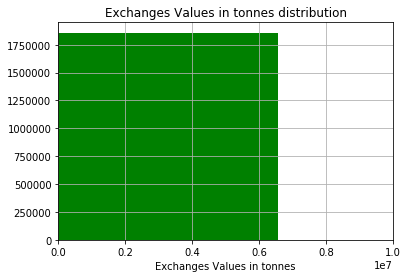

In [93]:

selected_live_stocks[selected_live_stocks['Unit']=='tonnes'].set_index('Item').Value.hist(facecolor='green', align='mid',bins= 10)
plt.xlim(xmin=0, xmax = 10**7)
plt.xlabel('Exchanges Values in tonnes')
plt.title('Exchanges Values in tonnes distribution')



Text(0.5, 1.0, 'Exchanges Values in K Dollars distribution')

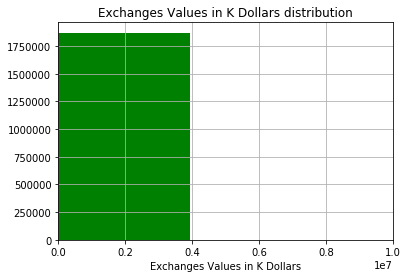

In [94]:

selected_live_stocks[selected_live_stocks['Unit']=='1000 US$'].set_index('Item').Value.hist(facecolor='green', align='mid',bins= 10)
plt.xlim(xmin=0, xmax =10**7)

plt.xlabel('Exchanges Values in K Dollars')
plt.title('Exchanges Values in K Dollars distribution')




Most of exchanges in tonnes ranges between $0-2*10^6$, some values go to $4*10^6$ tonnes\
Most of exchanges in Dollars ranges between $0-15*10^5$, some values go to $2*10^6$ dollars\
No particular error value are beeing observed nor specefic distribution (ex: uniform,gaussian...)\





Text(0.5, 1.0, 'Top 10 most exported crops in Quantity')

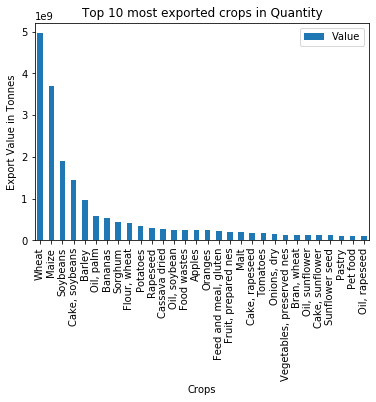

In [95]:
fig=selected_live_stocks[selected_live_stocks['Element'] == 'Export Quantity']\
                                                    .groupby(['Item'])['Value']\
                                                    .sum()\
                                                    .sort_values(ascending =False)\
                                                    .to_frame()[:30]\
                                                    .plot(kind='bar')   
fig.set_xlabel('Crops')
fig.set_ylabel('Export Value in Tonnes')
fig.set_title('Top 10 most exported crops in Quantity')

Text(0.5, 1.0, 'Top 10 most exported crops in Value')

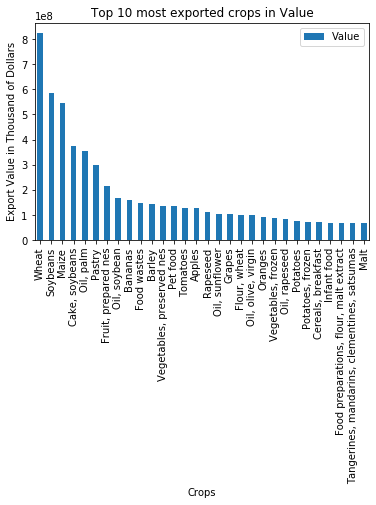

In [96]:
fig=selected_live_stocks[selected_live_stocks['Element'] == 'Export Value']\
                                                    .groupby(['Item'])['Value']\
                                                    .sum()\
                                                    .sort_values(ascending =False)\
                                                    .to_frame()[:30]\
                                                    .plot(kind='bar')
fig.set_xlabel('Crops')
fig.set_ylabel('Export Value in Thousand of Dollars')
fig.set_title('Top 10 most exported crops in Value')


In [97]:
selected_live_stocks[selected_live_stocks['Element'] == 'Export Quantity']\
                                                    .groupby(['Item','Item Code','Unit'])['Value']\
                                                    .sum()\
                                                    .sort_values(ascending =False)\
                                                    .to_frame()[:10]\

,,,Value
Item,Item Code,Unit,
Wheat,15,tonnes,4.964318e+09
Maize,56,tonnes,3.688698e+09
Soybeans,236,tonnes,1.898618e+09
"Cake, soybeans",238,tonnes,1.457406e+09
Barley,44,tonnes,9.574714e+08
"Oil, palm",257,tonnes,5.787275e+08
Bananas,486,tonnes,5.387601e+08
Sorghum,83,tonnes,4.282439e+08
"Flour, wheat",16,tonnes,4.033389e+08


In [98]:
selected_live_stocks[selected_live_stocks['Element'] == 'Export Value']\
                                                    .groupby(['Item','Item Code','Unit'])['Value']\
                                                    .sum()\
                                                    .sort_values(ascending =False)\
                                                    .to_frame()[:10]\

,,,Value
Item,Item Code,Unit,
Wheat,15,1000 US$,824027356.0
Soybeans,236,1000 US$,585520796.0
Maize,56,1000 US$,545500936.0
"Cake, soybeans",238,1000 US$,374035507.0
"Oil, palm",257,1000 US$,354954452.0
Pastry,22,1000 US$,299324586.0
"Fruit, prepared nes",623,1000 US$,215899171.0
"Oil, soybean",237,1000 US$,167687358.0
Bananas,486,1000 US$,160037908.0


In [99]:
selected_live_stocks[selected_live_stocks['Element'] == 'Export Value']\
                                                    .groupby(['Item','Item Code','Unit'])['Value']\
                                                    .sum()\
                                                    .sort_values(ascending =False)\
                                                    .to_frame()[:10]\

,,,Value
Item,Item Code,Unit,
Wheat,15,1000 US$,824027356.0
Soybeans,236,1000 US$,585520796.0
Maize,56,1000 US$,545500936.0
"Cake, soybeans",238,1000 US$,374035507.0
"Oil, palm",257,1000 US$,354954452.0
Pastry,22,1000 US$,299324586.0
"Fruit, prepared nes",623,1000 US$,215899171.0
"Oil, soybean",237,1000 US$,167687358.0
Bananas,486,1000 US$,160037908.0


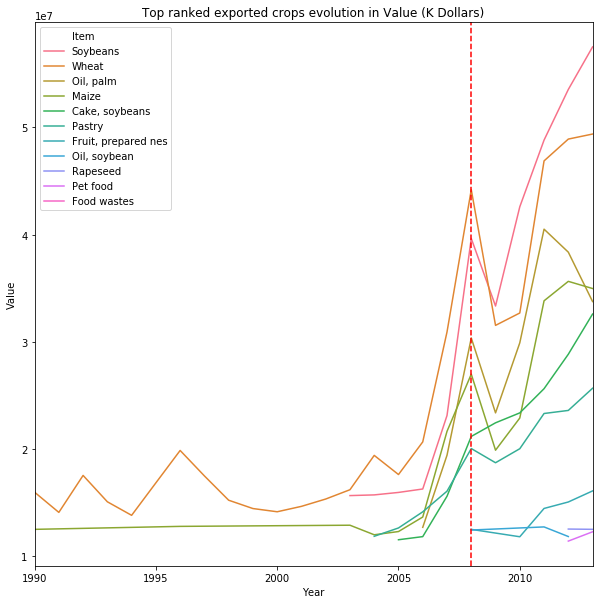

In [100]:
x= selected_live_stocks[selected_live_stocks['Element'] == 'Export Value']\
                                                    .groupby(['Year','Item'])['Value']\
                                                    .sum()\
                                                    .sort_values(ascending =False)\
                                                    .to_frame()[:100]\
                                                    .reset_index()
plt.figure(figsize=(10,10))


ax = sns.lineplot(x="Year", y="Value", hue="Item",
                   data=x)

ax.set_title('Top ranked exported crops evolution in Value (K Dollars)')
ax.set_xlim([1990,2013])
plt.axvline(2008, 0,10**7,color='r', linestyle='--')



(1990, 2013)

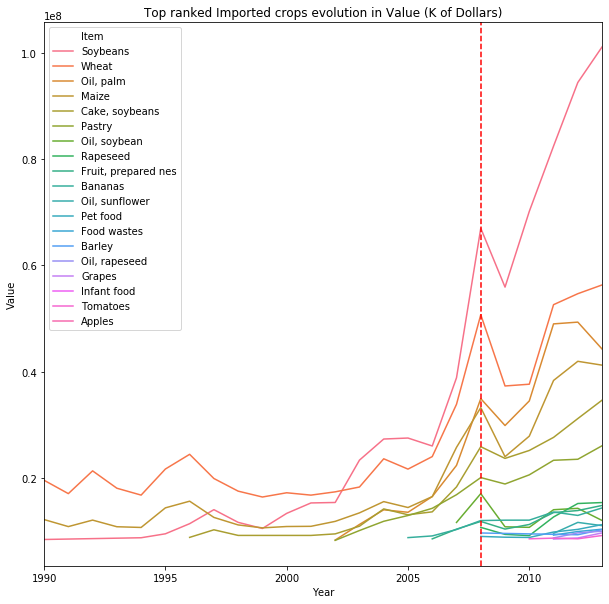

In [101]:
x= selected_live_stocks[selected_live_stocks['Element'] == 'Import Value']\
                                                    .groupby(['Year','Item'])['Value']\
                                                    .sum()\
                                                    .sort_values(ascending =False)\
                                                    .to_frame()\
                                                    .reset_index()[:200]

plt.figure(figsize=(10,10))
ax = sns.lineplot(x="Year", y="Value", hue="Item",
                   data=x)
plt.axvline(2008, 0,10**7,color='r',linestyle='--')

ax.set_title('Top ranked Imported crops evolution in Value (K of Dollars)')

ax.set_xlim([1990,2013])




(1990, 2013)

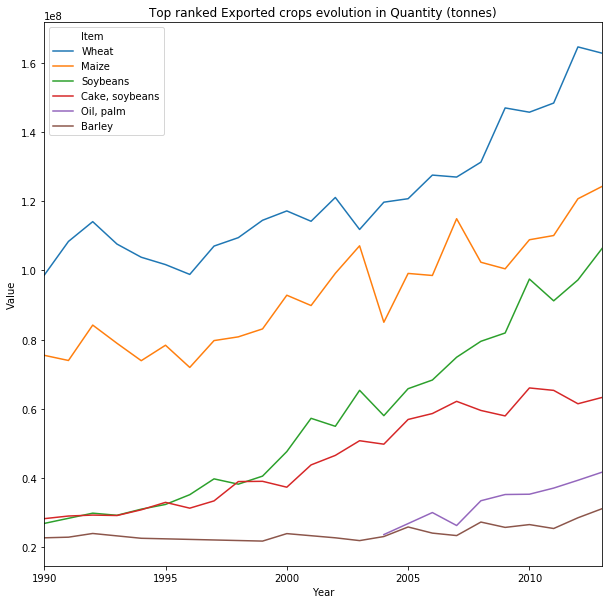

In [102]:
x= selected_live_stocks[selected_live_stocks['Element'] == 'Export Quantity']\
                                                    .groupby(['Year','Item'])['Value']\
                                                    .sum()\
                                                    .sort_values(ascending =False)\
                                                    .to_frame()[:200]\
                                                    .reset_index()
plt.figure(figsize=(10,10))


ax = sns.lineplot(x="Year", y="Value", hue="Item",
                   data=x)

ax.set_title('Top ranked Exported crops evolution in Quantity (tonnes)')

ax.set_xlim([1990,2013])



(1990, 2013)

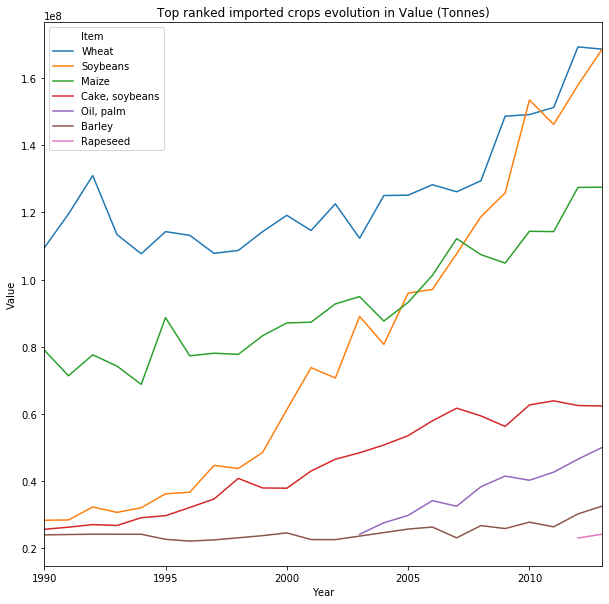

In [103]:
x= selected_live_stocks[selected_live_stocks['Element'] == 'Import Quantity']\
                                                    .groupby(['Year','Item'])['Value']\
                                                    .sum()\
                                                    .sort_values(ascending =False)\
                                                    .to_frame()[:200]\
                                                    .reset_index()
plt.figure(figsize=(10,10))


ax = sns.lineplot(x="Year", y="Value", hue="Item",
                   data=x)

ax.set_title('Top ranked imported crops evolution in Value (Tonnes)')
ax.set_xlim([1990,2013])





Plots gives some insights on price evolution top ranked exchanged crops. For instance one can observe prices inflation in value plots right at the **2008** economic crises. 

We can as well get insights in food trend identification. For instance, soybeans rapid increase over the years can be a sign of trend around this commodity.



***Year***

In [104]:
clean_live_stocks.Year.unique()

array([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013], dtype=int64)

Time frame convered spans form 1961-2013

***Flags***

In [105]:
clean_live_stocks.Flag.unique()

array([nan, '*', 'F', 'R', 'A'], dtype=object)

Nan : Official Data \
\* : Unofficial Figure\
F : FAO estimate \
R : Estimated data using trading partners database\
A : Aggregate, may include official, semi-official, estimated or calculated data

In [106]:
clean_live_stocks.groupby('Flag')['Area Code'].sum().nlargest()

Flag
A    16954569990
F       79355063
*       44393818
R       26461451
Name: Area Code, dtype: int64

NaN          5590861



### Question insights 

In this project, we are interested in specific crops investigation in terms of global demand, production quantity... 

Ability of chosing between different scales, crops categories and commodities will allow deeper investigation.

Lets select Bananas as it was them most exchanged commidty across the years and investigate the role of different countries. 


(1990, 2013)

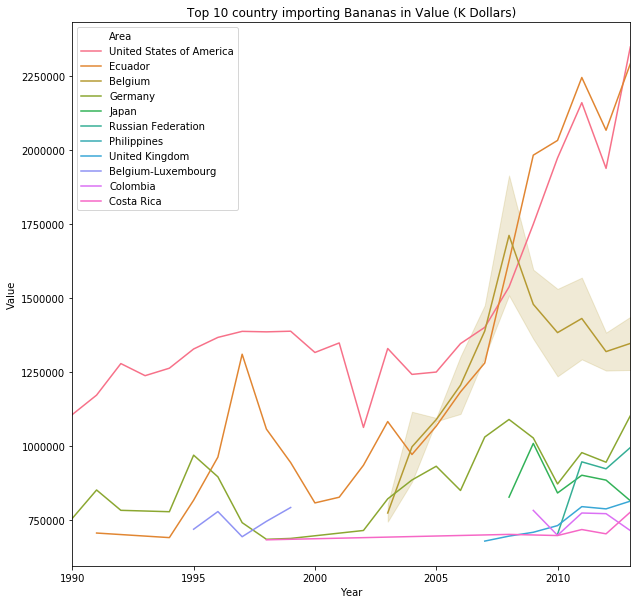

In [107]:
Banana_live_stocks= countries_live_stock[countries_live_stock['Item'] == 'Bananas'].copy()


x= Banana_live_stocks[Banana_live_stocks['Unit'] == '1000 US$']\
                                                    .groupby(['Year','Area','Element'])['Value']\
                                                    .sum()\
                                                    .sort_values(ascending =False)\
                                                    .to_frame()[:130]\
                                                    .reset_index()
plt.figure(figsize=(10,10))


ax = sns.lineplot(x="Year", y="Value", hue="Area",
                   data=x)

ax.set_title('Top 10 country importing Bananas in Value (K Dollars)')
ax.set_xlim([1990,2013])




(1990, 2013)

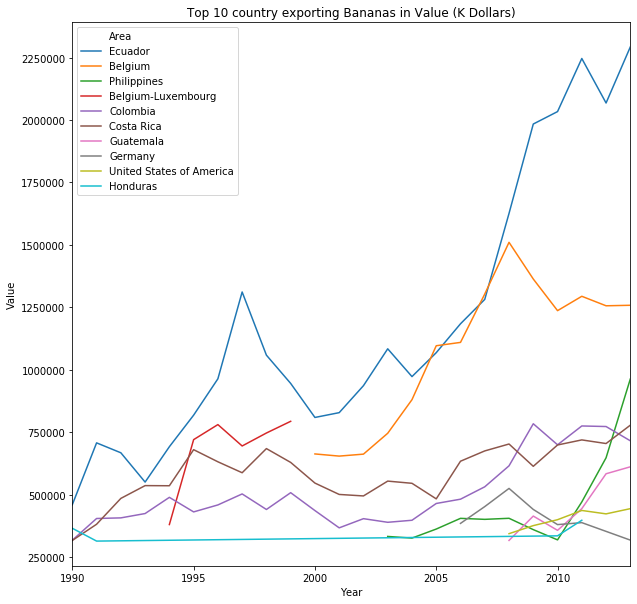

In [108]:

Banana_live_stocks= countries_live_stock[countries_live_stock['Item'] == 'Bananas'].copy()


x= Banana_live_stocks[Banana_live_stocks['Element'] == 'Export Value']\
                                                    .groupby(['Year','Area'])['Value']\
                                                    .sum()\
                                                    .sort_values(ascending =False)\
                                                    .to_frame()[:130]\
                                                    .reset_index()
plt.figure(figsize=(10,10))


ax = sns.lineplot(x="Year", y="Value", hue="Area",
                   data=x)

ax.set_title('Top 10 country exporting Bananas in Value (K Dollars)')

ax.set_xlim([1990,2013])



(1990, 2013)

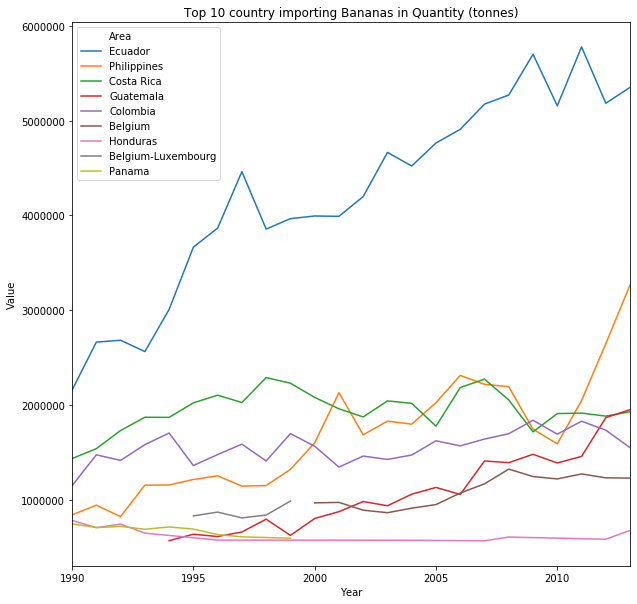

In [109]:
Banana_live_stocks= countries_live_stock[countries_live_stock['Item'] == 'Bananas'].copy()


x= Banana_live_stocks[Banana_live_stocks['Element'] == 'Export Quantity']\
                                                    .groupby(['Year','Area'])['Value']\
                                                    .sum()\
                                                    .sort_values(ascending =False)\
                                                    .to_frame()[:270]\
                                                    .reset_index()
plt.figure(figsize=(10,10))


ax = sns.lineplot(x="Year", y="Value", hue="Area",
                   data=x)

ax.set_title('Top 10 country importing Bananas in Quantity (tonnes)')
ax.set_xlim([1990,2013])



Those plots can give some interesting insights on commodity market and exchanges. For instance Belgium ranks as second biggest exporter of bananas in Value.\
However in quantity it is the 5th one. Same for Importation.
One could think that Belgium doesn't produce bananas but only act as an intermedier,buying low, selling high in the banana market. \
To confirm this statement, we could investigate belgium production area for bananas in crop data set. 



(1990, 2013)

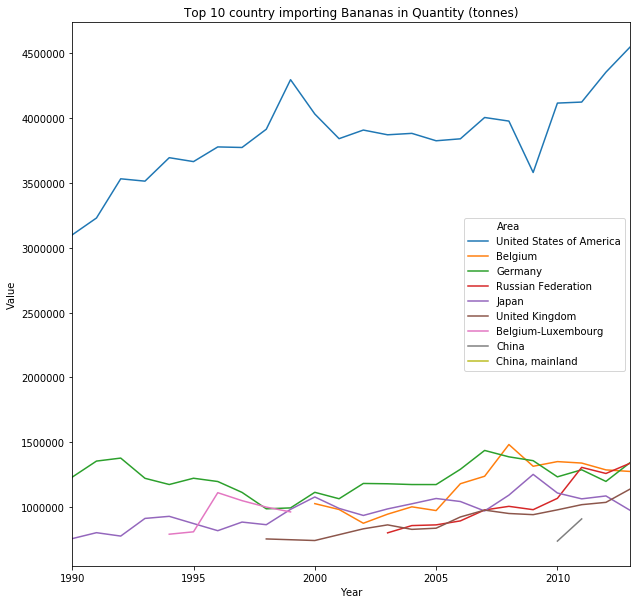

In [110]:
Banana_live_stocks= countries_live_stock[countries_live_stock['Item'] == 'Bananas'].copy()


x= Banana_live_stocks[Banana_live_stocks['Element'] == 'Import Quantity']\
                                                    .groupby(['Year','Area'])['Value']\
                                                    .sum()\
                                                    .sort_values(ascending =False)\
                                                    .to_frame()[:170]\
                                                    .reset_index()
plt.figure(figsize=(10,10))



ax = sns.lineplot(x="Year", y="Value", hue="Area",
                   data=x)

ax.set_title('Top 10 country importing Bananas in Quantity (tonnes)')
ax.set_xlim([1990,2013])



## Correlation

Correlation comes in handy for data set investigation and understanding. One could question inner feature relationships as well as 
as relationships with other feature.\
In our case correlation between export and import in quantity and value could reveal interesting information on pricing evolution with respect to global food demand.\
In this project we also question the link between production and global food demand. Using bananas as an exemple we could start answering that question. 



Lets us now make an item Centric Dataframe to investigate correlation beween Export and Import both in Quantity and Values.

In [111]:

x= selected_live_stocks.groupby(['Element','Item'])['Value']\
                                                    .sum()\
                                                    .to_frame()
   
item_centric = pd.concat([x.loc['Export Quantity'].rename(columns={ 'Value':'ExpQuantity'}),\
                   x.loc['Export Value'].rename(columns={ 'Value':'ExpValue'})\
                   ,x.loc['Import Quantity'].rename(columns={ 'Value':'ImpQuantity'}),\
                   x.loc['Import Value'].rename(columns={ 'Value':'ImpValue'})],\
                   axis = 1,sort=False).sort_values(by=["ExpQuantity",'ExpValue','ImpQuantity','ImpValue'], ascending = False)
item_centric.head()

,ExpQuantity,ExpValue,ImpQuantity,ImpValue
Wheat,4.964318e+09,824027356.0,5.276072e+09,976048199.0
Maize,3.688698e+09,545500936.0,3.719216e+09,634347704.0
Soybeans,1.898618e+09,585520796.0,2.442040e+09,879262316.0
"Cake, soybeans",1.457406e+09,374035507.0,1.418449e+09,411812339.0
Barley,9.574714e+08,142277897.0,9.569074e+08,163450453.0


In [112]:
pd.concat([item_centric.min().rename('min'), item_centric.max().rename('max')], axis=1)


,min,max
ExpQuantity,0.0,4.964318e+09
ExpValue,0.0,8.240274e+08
ImpQuantity,0.0,5.276072e+09
ImpValue,0.0,9.760482e+08


We clearly see scale difference in the Values for each 'Unit'

Min MaxScaling will allow us to obtain reliable information for correlation 


In [113]:
from sklearn import preprocessing

item_centric_values = item_centric.values
min_max_scaler = preprocessing.MinMaxScaler()
item_centric_values = min_max_scaler.fit_transform(item_centric_values)
item_centric_normalized = pd.DataFrame(item_centric_values, columns=item_centric.columns)

In [114]:
item_centric_normalized.corr()

,ExpQuantity,ExpValue,ImpQuantity,ImpValue
ExpQuantity,1.000000,0.891058,0.997404,0.886295
ExpValue,0.891058,1.000000,0.899517,0.990329
ImpQuantity,0.997404,0.899517,1.000000,0.902547
ImpValue,0.886295,0.990329,0.902547,1.000000


C:\Users\celio\Anaconda3\lib\site-packages\numpy\lib\histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\celio\Anaconda3\lib\site-packages\numpy\lib\histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


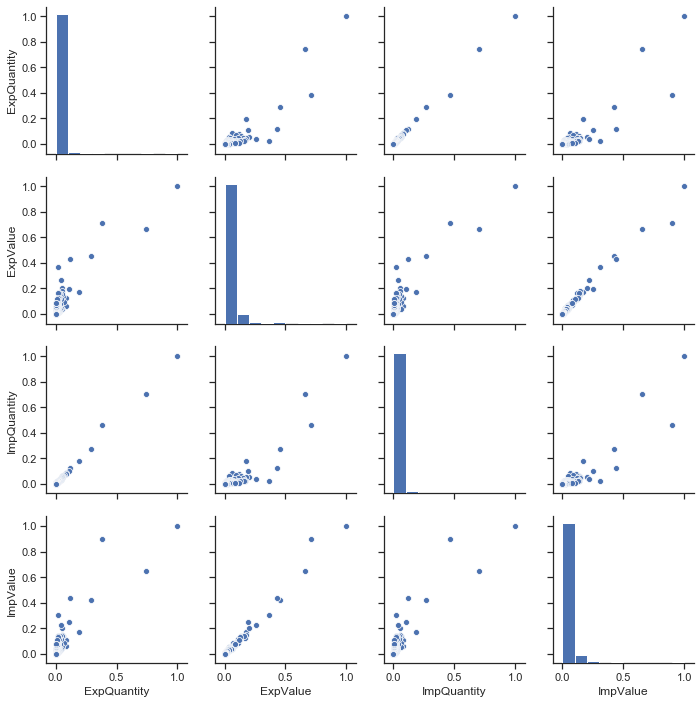

In [115]:
sns.set(style="ticks")
sns.pairplot(item_centric_normalized)

... Let us now focus on bananas with a year centric Data Frame. 

In [116]:
#Processing the banana production per year output from corps to make it complient for merging 
bananas = pd.read_csv(datapath + current_fao +"bananas_prod.csv",sep=",", encoding="latin_1")
sum_ = bananas.groupby('year')['value'].sum().sort_values(ascending =False)\
                                        .to_frame()\
                                        .reset_index()
sum_=sum_.rename(columns={'year':'Year'})
sum_=sum_.rename(columns={'value':'Surface Production'})

sum_.Year= sum_.Year.apply(lambda x: int(x))
sum_.head()


,Year,Surface Production
0,2007,93652856.0
1,2006,89788488.0
2,2005,85267584.0
3,2004,80866125.0
4,2003,76112799.0


In [117]:
x= selected_live_stocks[selected_live_stocks['Item']=='Bananas'].groupby(['Element','Year'])['Value']\
                                                    .sum().sort_values(ascending =False)\
                                                    .to_frame()
 
year_centric = pd.concat([x.loc['Export Quantity'].rename(columns={'Value':'ExpQuantity'}),\
                         x.loc['Import Quantity'].rename(columns={'Value':'ImpQuantity'})],axis = 1,sort=False)\
                        .sort_values(by=["ExpQuantity",'ImpQuantity'], ascending = False).reset_index()[6:-1]\
                        .reset_index()
                         


year_centric.Year=year_centric.Year.apply(lambda x: int(x))
year_centric['Surface Production']= sum_['Surface Production']
year_centric=year_centric.drop(columns = ['index','Year'])
year_centric.head()

,ExpQuantity,ImpQuantity,Surface Production
0,17527838.0,18672487.0,93652856.0
1,17001013.0,16876259.0,89788488.0
2,16383011.0,15855090.0,85267584.0
3,15725886.0,15538832.0,80866125.0
4,15297949.0,15187577.0,76112799.0


In [118]:
year_centric.corr()

,ExpQuantity,ImpQuantity,Surface Production
ExpQuantity,1.000000,0.99719,0.982888
ImpQuantity,0.997190,1.00000,0.982180
Surface Production,0.982888,0.98218,1.000000


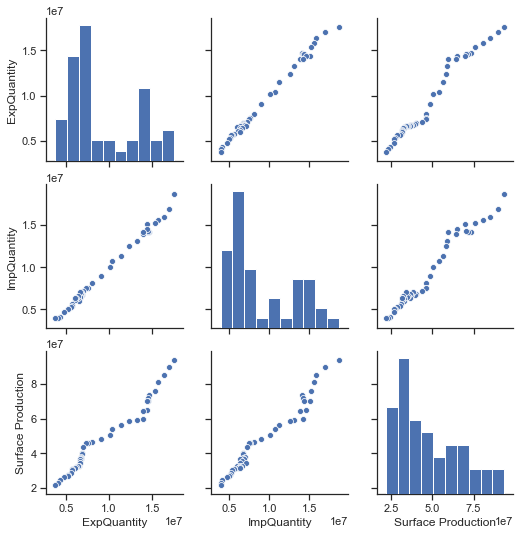

In [119]:
sns.set(style="ticks")
sns.pairplot(year_centric)

`Output`: Interestingly, production quantity is also correlated with both export and import. It gives insight on how coutry production increases in respond to global demand instead of local market queries. 

## Conclusion   :
Data contains missing values, only the ones in the Value feature were discarded. Data contains information regarding the exchanges (import and export) per countrie, region and continent. Exchanges are both explained in termes of value (Thousands of dollars) and quantity (tonnes). All kinds of crops figure in the Item feature as single items as well as per categories. The processing was made so that we can easly chose a focus on a specific category of crops, chose between different scales. Correlations were made to provide insights on the questions asked as well as data set investigation. 


<a id="questions"></a>
## Data to Answer the Questions 


##### Question 1. 
What is the global evolution of the cultivated surface per country from 1995 to 2007?

(1995, 2007)

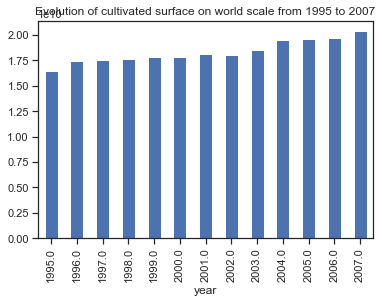

In [120]:
#use of the Crops data frame: 
world_surface = crops[(crops.country_or_area == 'World +') \
                      & (crops.year >= 1995) & (crops.year <= 2007)]\
                        .groupby('year')['value'].sum()
world_surface.plot(kind='bar')
plt.title('Evolution of cultivated surface on world scale from 1995 to 2007')
ax.set_xlim([1995,2007])

We will do this processing for all the countries. 

##### Question 2. 
What is the area lost of savanna, shrubland, grassland and forest per country per year?

We will do the same processing than for the `Crops` data set for all the countries. 

In [121]:
biomesCountry.head()

,Country,Land,Ecosystem,Year,Area_loss,Area_loss_percentage
0,Canada,9.09351e+08,Forest,1995,523800.0,0.057602
1,Canada,9.09351e+08,Forest,1996,523800.0,0.057602
2,Canada,9.09351e+08,Forest,1997,523800.0,0.057602
3,Canada,9.09351e+08,Forest,1998,523800.0,0.057602
4,Canada,9.09351e+08,Forest,1999,523800.0,0.057602


##### Question 3. 
Do we see a correlation between the area lost by ecosystems and the area gain by agriculture?

For this question we will use results of `Question 1.` and `Question 2.`

In [122]:
#Operation to keep only what is needed in this question for the "Crops" dataframe:
cropsHa=crops.where(crops['element']=='Area Harvested')
cropsHa=cropsHa.where(crops['year']>1994).dropna().astype({'year':'int64'})
cropsHa = cropsHa.drop(['unit', 'element'], axis=1)\
                 .rename(columns={"value": "Area_cultivated","country_or_area": "Country", "year":"Year"})
cropsHa.head(-1)

,Country,Year,Area_cultivated,category
0,Americas +,2007,49404.0,agave_fibres_nes
1,Americas +,2006,49404.0,agave_fibres_nes
2,Americas +,2005,49404.0,agave_fibres_nes
3,Americas +,2004,49113.0,agave_fibres_nes
4,Americas +,2003,48559.0,agave_fibres_nes
...,...,...,...,...
2255209,World +,2000,34258.0,yautia_cocoyam
2255210,World +,1999,33897.0,yautia_cocoyam
2255211,World +,1998,32078.0,yautia_cocoyam
2255212,World +,1997,33884.0,yautia_cocoyam


In [123]:
# Perform the sum of all the area cultivated independetly of the crop type:
totalCropsHa=cropsHa.groupby(['Country', 'Year', ]).Area_cultivated.sum().to_frame()
totalCropsHa.head(-1)

Area_cultivated
Country     Year                 
Afghanistan 1995        9729690.0
            1996        9482690.0
            1997        9562790.0
            1998        9765590.0
            1999        8932590.0
...                           ...
Zimbabwe    2002        9820673.0
            2003        9902783.0
            2004       10457568.0
            2005       10891846.0
            2006       11431173.0

[3155 rows x 1 columns]

In [124]:
# Perform the sum of all the area losses independetly of the ecosystem:
#biomesCountry=biomesCountry[(biomesCountry != 0).all(1)]
totalBiomesCountry=biomesCountry.groupby(['Country', 'Year']).Area_loss.sum().to_frame()
totalBiomesCountry.head(-1)

Area_loss
Country     Year              
Afghanistan 1995  2.507324e+04
            1996  2.606821e+04
            1997  1.862108e+04
            1998  5.100797e+04
            1999  3.067655e+04
...                        ...
Zimbabwe    2002  2.274862e+06
            2003  2.191446e+06
            2004  3.387613e+06
            2005  3.068317e+06
            2006  3.018875e+06

[2450 rows x 1 columns]

In [125]:
loss_cultivated=totalBiomesCountry.merge(totalCropsHa, on=['Country','Year'])
loss_cultivated.head(-1)

Area_loss  Area_cultivated
Country     Year                               
Afghanistan 1995  2.507324e+04        9729690.0
            1996  2.606821e+04        9482690.0
            1997  1.862108e+04        9562790.0
            1998  5.100797e+04        9765590.0
            1999  3.067655e+04        8932590.0
...                        ...              ...
Zimbabwe    2002  2.274862e+06        9820673.0
            2003  2.191446e+06        9902783.0
            2004  3.387613e+06       10457568.0
            2005  3.068317e+06       10891846.0
            2006  3.018875e+06       11431173.0

[2216 rows x 2 columns]

In [126]:
loss_cultivated.corr()

,Area_loss,Area_cultivated
Area_loss,1.000000,0.091906
Area_cultivated,0.091906,1.000000


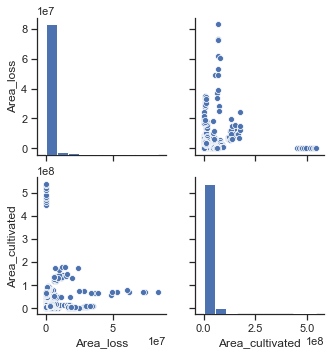

In [127]:
sns.set(style="ticks")
sns.pairplot(loss_cultivated);

##### Question 4. 
For each selected crop, sojabean, banana, wheat, rice and palm oil, what pourcentage of the total cultivated area do they represent? 

We will show how we will answer this question with the example of `Bananas`. We will use first the data obtained from the web scrapping and added to the dataframe containing the burned areas of the biomes. Then, we will compare it to the `Crops` dataset.

##### Question 5. 
If there is a correlation between an increase in area cultivated and area lost from all the ecosystems, what would be approximatively the area lost because of the selected crops in particular?

We will need the 3 data sets here, each time for the specific crop. For the `Crops` dataset we will need to have the area harvested by countries, maybe grouping by continents. For the `Biomes`, we will need the area lost by countries by year. Finally, for the `Livestock` dataset, we will need the global importation of the products we study. 

##### Question 6. 
Are sojabean, banana, wheat, rice and palm oil meant for exportation and/or importation for each country over the years? Check more precisely for different economical segments and regions.

We will need the `Livestock` dataset and study the importation and exportation and the production quantity of the product in the data set `Crops` and then link the informations. We will do it first for the countries individually and then for the economical segments and the regional areas too. 

##### Question 7. 
How can we identify  short term food trends and what is its impact on the global and country wise area loss?

Using `LiveStock` to assert global food demand evolution for specfic commodities (or crops) combined with `Crops` information on production quantity evolution,  one could find patterns or metrics for a global consumption trend. If we correlate with `Savanna` and `Forest`, we might as well assess the destructive impact of the observed trendy items. 

## World Map: Test

In [128]:
import geopandas as gpd
import json

In [129]:
shapefile = 'Data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp'
#Read shapefile using Geopandas
gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
#Rename columns.
gdf.columns = ['Country', 'country_code', 'geometry']
gdf.head()

,Country,country_code,geometry
0,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,United Republic of Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,Western Sahara,SAH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [130]:
print(gdf[gdf['Country'] == 'Antarctica'])
#Drop row corresponding to 'Antarctica'
gdf = gdf.drop(gdf.index[159])

        Country country_code  \
159  Antarctica          ATA   

                                              geometry  
159  MULTIPOLYGON (((-48.66062 -78.04702, -48.15140...  


In [473]:
#datasets for the biomes 

biomesCountry_savan = biomesCountry[biomesCountry['Ecosystem'] == 'Savanna']
biomesCountry_shrub = biomesCountry[biomesCountry['Ecosystem'] == 'Shrubland']
biomesCountry_grass = biomesCountry[biomesCountry['Ecosystem'] == 'Grassland']
biomesCountry_forest = biomesCountry[biomesCountry['Ecosystem'] == 'Forest']

In [467]:
from bokeh.io import curdoc, output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LogColorMapper, ColorBar, Slider, HoverTool, LogTicker, LinearColorMapper
from bokeh.models import ColorBar, LogTicker, BasicTicker
from bokeh.palettes import brewer
from bokeh.layouts import widgetbox, row, column

    
def json_fct(infoToPlot, selectedYear, selectedDataSet):
    yr = selectedYear
    #changes here:
    df_yr = selectedDataSet[selectedDataSet['Year'] == yr]
    merged = gdf.merge(df_yr, left_on = 'Country', right_on = 'Country', how = 'left')    
    #Replace NaN values to string 'No data'.
    merged[infoToPlot].fillna('No data', inplace = True)
    merged_json = json.loads(merged.to_json())
    json_data = json.dumps(merged_json)
    return json_data


# Define the callback function: update_plot
def update_plot(attr, old, new):
    yr = slider.value
    new_data = json_data(yr)
    geosource.geojson = new_data
    p.title.text = title + ' in %d' %yr

    
def makeMap(title, legend, infoToPlot, selectedYear, selectedDataSet, Scale, palette, lin): 
    #Input GeoJSON source that contains features for plotting.
    geosource = GeoJSONDataSource(geojson = json_fct(infoToPlot, selectedYear, selectedDataSet))
    #Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors. Input nan_color.
    #changes here:
    
    if (lin): 
        #Define a sequential multi-hue color palette.
        grad=round(Scale[1]/0.1,0)
        palette = brewer[palette][grad]
        #Reverse color order so that dark red is highest loss.
        palette = palette[::-1]
        color_mapper = LinearColorMapper(palette = palette, low=Scale[0], high=Scale[1],  nan_color = '#d9d9d9')
        #Define custom tick labels for color bar.
        tick_labels = {'0': '0%', '0.1': '0.1%', '0.2': '0.2%', '0.3': '0.3%', '0.4': '0.4%', '0.5': '0.5%','0.6':'0.6%', '0.7':'0.7%', '0.8':'0.8%', '0.9':'0.9%'}
        #Create color bar. 
        color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
                         border_line_color=None, location = (0,0), orientation = 'horizontal', major_label_overrides = tick_labels)
    else: 
        #Define a sequential multi-hue color palette.
        grad=round(np.log10(Scale[1]/Scale[0]),0)
        palette = brewer[palette][grad]
        #Reverse color order so that dark red is highest loss.
        palette = palette[::-1]
        color_mapper = LogColorMapper(palette = palette, low =Scale[0], high =Scale[1], nan_color = '#d9d9d9')
        #Define custom tick labels for color bar.
        tick_labels = {'100': '1e-6%', '1000': '1e-5%', '10000': '1e-4%', '100000': '1e-3%', '1000000': '0.01%', '10000000': '0.1%', '100000000': '1%', '1000000000': '10%', '10000000000': '100%'}
        color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
                         border_line_color=None, location = (0,0), orientation = 'horizontal', ticker=LogTicker(), major_label_overrides = tick_labels)
    
    #Add hover tool
    hover = HoverTool(tooltips = [ ('Country','@Country'),(legend, '@'+infoToPlot)])
    #Create figure object.
    p = figure(title =  title, plot_height = 600 , plot_width = 950, toolbar_location = None, tools = [hover])
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    #Add patch renderer to figure. 
    p.patches('xs','ys', source = geosource, fill_color = {'field' :infoToPlot, 'transform' : color_mapper},
              line_color = 'black', line_width = 0.25, fill_alpha = 1)
    #Specify layout
    p.add_layout(color_bar, 'below')
    
    # Make a slider object: slider 
    slider = Slider(title = 'Year',start = 1995, end = 2007, step = 1, value = 2007)
    slider.on_change('value', update_plot)
    # Make a column layout of widgetbox(slider) and plot, and add it to the current document
    layout = column(p,widgetbox(slider))
    curdoc().add_root(layout)
    #Display plot inline in Jupyter notebook
    output_notebook()
    #Display plot
    show(layout)


In [468]:
makeMap('Forest Losses', 'Area loss', 'Area_loss_number', 2007, biomesCountry_forest,[1e2,1e9], 'YlOrRd', False)

Loading BokehJS ...

You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/server.html



In [393]:
makeMap('Savanas Losses', 'Area loss', 'Area_loss_number', 2007, biomesCountry_savan,[1e3, 1e10] ,'YlOrRd', False)

Loading BokehJS ...

You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/server.html



In [401]:
makeMap('Shrubbland Losses', 'Area loss', 'Area_loss_number', 2007, biomesCountry_shrub, [1e2,1e9], 'YlOrRd', False)

Loading BokehJS ...

You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/server.html



In [403]:
makeMap('Grass Losses', 'Area loss', 'Area_loss_number', 2007, biomesCountry_grass,  [1e2,1e9], 'YlOrRd', False)

Loading BokehJS ...

You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/server.html



In [465]:
#if you want to change the products printed : can use 'crops_totals_area' instead
crops_area = crops_indiv_area.copy()

#clean the ab dataframe obtained from crop:
cropsCountries_area = crops_area.where(crops_area['year']>1994).dropna().astype({'year':'int64'})
cropsCountries_area = cropsCountries_area.drop(['unit', 'element'], axis=1)\
                                           .rename(columns={"value": "Area_cultivated","country_or_area": "Country", "year":"Year"})
#Sum up all categories:
cropsCountries_area_total = cropsCountries_area.groupby(['Country', 'Year']).Area_cultivated.agg(sum).reset_index()

#merge with the land datafram to do the percentage (area cultivated over total area of the country times 100)
land_areas['Land']=pd.to_numeric(land_areas['Land'],errors='coerce')
cropsCountries_area_total = land_areas.merge(cropsCountries_area_total, on='Country')
cropsCountries_area_total['Area_cultivated_percentage'] = cropsCountries_area_total['Area_cultivated']/cropsCountries_area_total['Land']

#Look at strange high percentage:
a=cropsCountries_area_total[cropsCountries_area_total['Area_cultivated_percentage']>2]
a.drop_duplicates()

C:\Users\celio\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,Country,Land,Year,Area_cultivated,Area_cultivated_percentage


In [472]:
#data set for the new cultured areas : can only start at 0 
makeMap('Cultured area Gain', 'Area Gain', 'Area_cultivated_percentage', 2007, cropsCountries_area_total, [0,0.4],'YlGnBu', True)

Loading BokehJS ...

You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/server.html

